# Intro

## Standard modules

In [2]:
import os, sys
import pathlib
import requests

In [3]:
import numpy as np

In [4]:
from tqdm.auto import tqdm, trange

In [5]:
from sentence_transformers import util

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [7]:
from sklearn.decomposition import PCA

In [8]:
import seaborn

In [9]:
import pymannkendall as mk

In [117]:
from scipy.spatial.distance import cosine

## Personal modules

In [10]:
from toolbox.updater import time_is_now

In [11]:
from file2text import file2text

In [12]:
from first_rough_cleaning import first_text_cleaner

In [13]:
from file_handler import *

In [14]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [15]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [16]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [17]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

## Witten's vector

In [18]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [19]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

## Load vectors

In [231]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [232]:
vecfiles.sort()

### Goals' vectors

#### Load files

In [233]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [234]:
goalvecfiles.sort()

In [235]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [236]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

#### Reorganize the folder **[NOT NECESSARILY TO BE RUN AGAIN]**

In [227]:
for goalvecfile in goalvecfiles:
    num=goalvecfile.split('_')[0].split('-')[1]
    if len(num)==1:
        new_name='Goal-'+num.zfill(2)+'-Fast-Facts.txt'
        os.rename(PCA_CENTR_VECTOR_FOLDER+goalvecfile, PCA_CENTR_VECTOR_FOLDER+new_name)

### Reports' vectors

In [42]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [61]:
reports_files.sort()

In [45]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [48]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [141]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [142]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

# Helper

## Sector helper

In [270]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [271]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [272]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

## SDG helper

In [274]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

# Increasing trend?

In [91]:
years=years.astype('i4')

## Global

In [148]:
cos_sims_global=np.zeros(len(years), dtype=[('mean', 'f8'), ('all', object)])

In [149]:
for i_y, year in enumerate(tqdm(years)):

    
    cos_sims_global[i_y]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[vectors['year']==year]['vector']])
    cos_sims_global[i_y]['mean']=np.mean(cos_sims_global[i_y]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

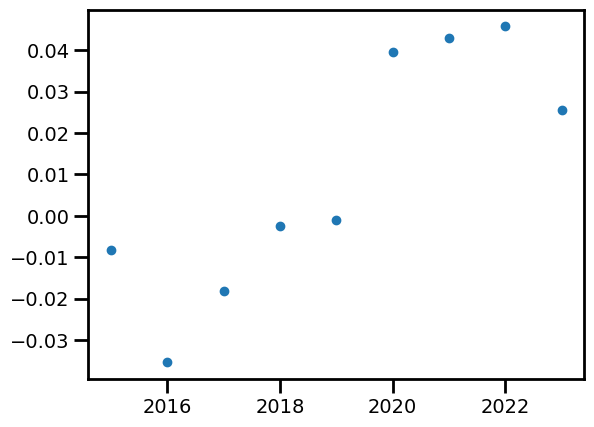

In [151]:
plt.scatter(np.arange(2015, 2024), cos_sims_global['mean'])
plt.show()

In [158]:
type(cos_sims_global['all'])

numpy.ndarray

In [167]:
data_for_seaborn={years[i]:list(_) for i, _ in enumerate(cos_sims_global['all'])}

<Axes: >

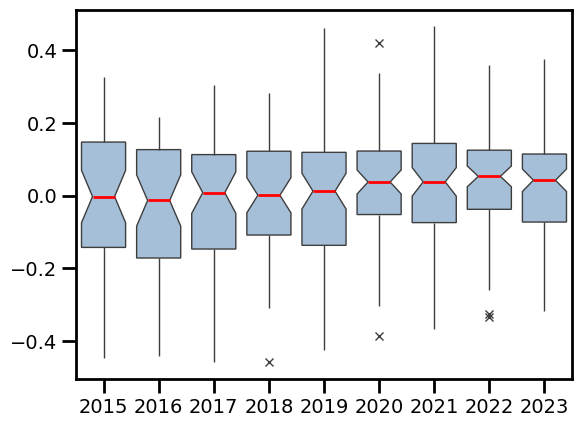

In [168]:
seaborn.boxplot(data=data_for_seaborn, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2})

Mann-Kendall required?

## By sector

In [170]:
secs, k_secs=np.unique(vectors['sector'], return_counts=True)

In [171]:
np.vstack((secs, k_secs)).T

array([['01', '61'],
       ['02', '82'],
       ['03', '84'],
       ['04', '47'],
       ['05', '52'],
       ['06', '41'],
       ['07', '54'],
       ['08', '49'],
       ['09', '25'],
       ['10', '37'],
       ['11', '41']], dtype='<U21')

In [347]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

In [175]:
cos_sims_by_sec=np.zeros(len(years)*len(secs), dtype=[('year', 'i4'),('sector', 'U2'),('mean', 'f8'), ('all', object)])

In [188]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sec in enumerate(secs):
        cos_sims_by_sec[i_y*len(secs)+i_s]['year']=year
        cos_sims_by_sec[i_y*len(secs)+i_s]['sector']=sec
        cos_sims_by_sec[i_y*len(secs)+i_s]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
        cos_sims_by_sec[i_y*len(secs)+i_s]['mean']=np.mean(cos_sims_by_sec[i_y*len(secs)+i_s]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

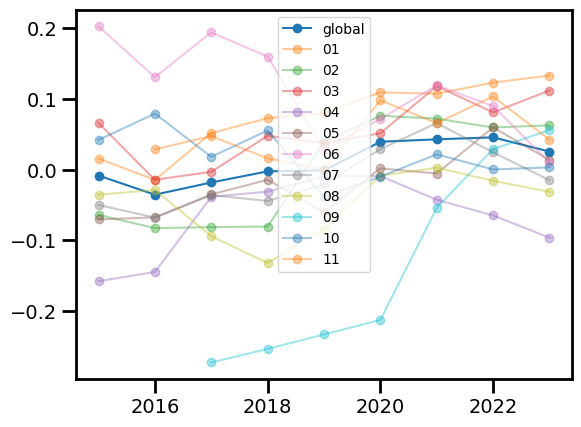

In [193]:
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
for sec in secs:
    plt.plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
plt.legend()
plt.show()

## By SDG

In [276]:
sdgs=[] 
for goalvecfile in goalvecfiles:
    sdg=goalvecfile.split('_')[0].split('-')[1]
    if sdg.isnumeric():
        sdgs.append(sdg)

In [278]:
cos_sims_by_sdg=np.zeros(len(years)*len(goalvecfiles), dtype=[('year', 'i4'),('SDG', 'U2'),('mean', 'f8'), ('all', object)])

In [280]:
vectors.dtype

dtype([('year', '<i4'), ('sector', '<U2'), ('company', '<U100'), ('vector', 'O')])

In [282]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sdg in enumerate(sdgs):
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['year']=year
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['SDG']=sdg
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['all']=np.array([float(util.cos_sim(goalvecs[i_s], vec)) for vec in vectors[vectors['year']==year]['vector']])
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['mean']=np.mean(cos_sims_by_sdg[i_y*len(sdgs)+i_s]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

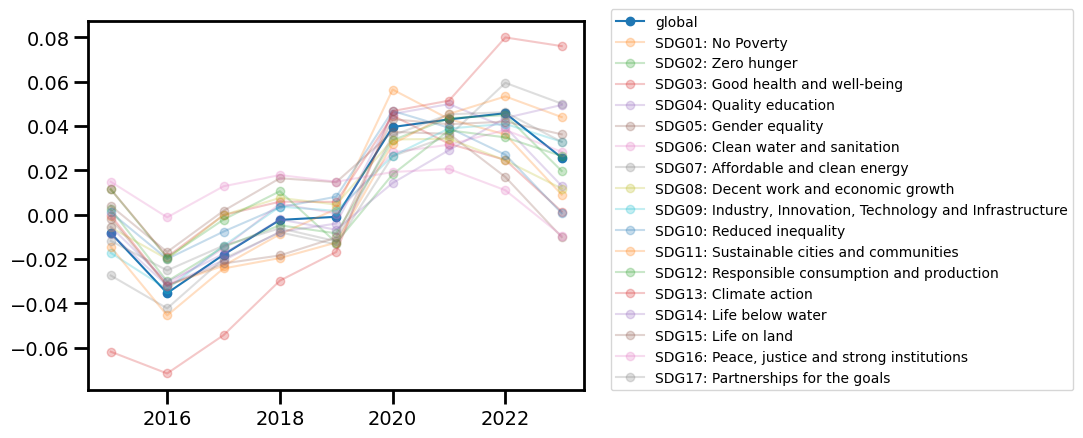

In [306]:
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
for sdg in sdgs:
    plt.plot(cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['year'], cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['mean'], marker='o', label='SDG'+sdg+': '+sdg_helper[sdg], alpha=0.25)
plt.legend(loc=1, bbox_to_anchor=(2.0, 1.05))
plt.show()

## By sector, by SDG

In [242]:
cos_sims_by_sec_by_SDG=np.zeros(len(years)*len(secs)*len(goalvecfiles), dtype=[('year', 'i4'),('sector', 'U2'),('SDG', 'U2'),('mean', 'f8'), ('all', object)])

In [258]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sec in enumerate(secs):
        for i_sdg, sdg in enumerate(sdgs):
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['year']=year
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['sector']=sec
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['SDG']=sdg
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['all']=np.array([float(util.cos_sim(goalvecs[i_sdg], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['mean']=np.mean(cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


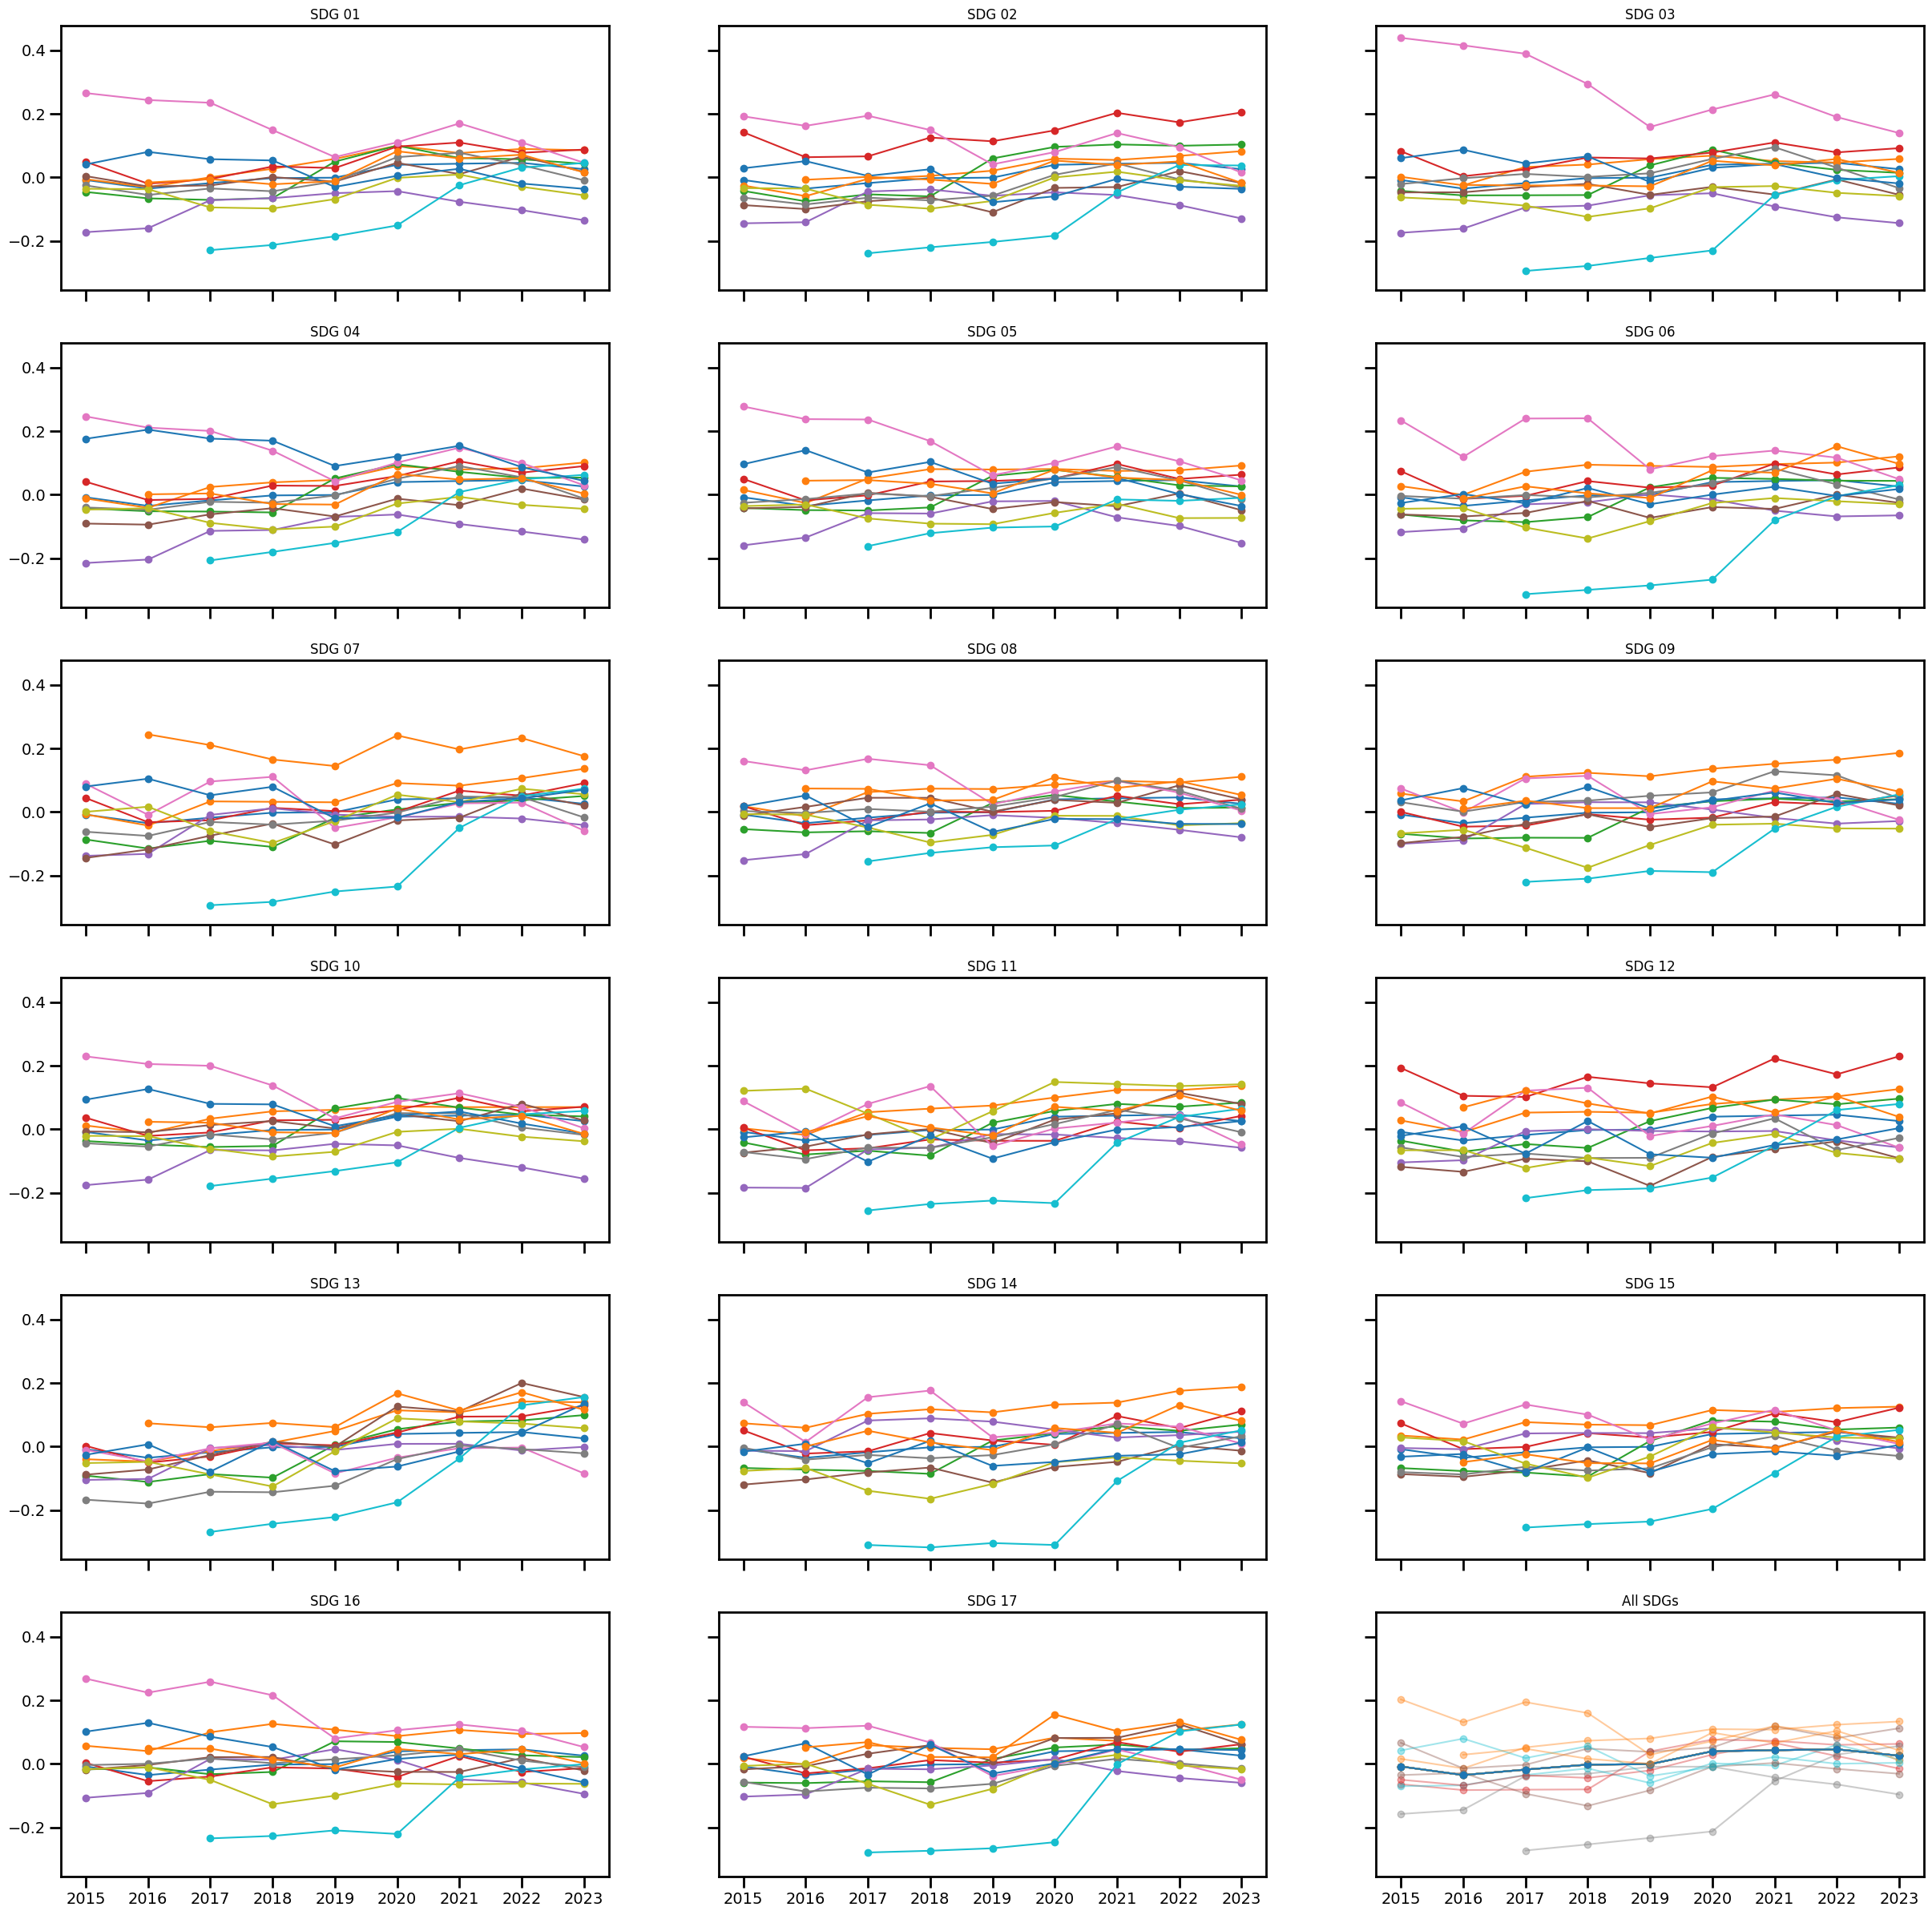

In [273]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
for sec in secs:
    axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
    axs[5,2].set_title('All SDGs')

plt.show()

To be improved.

## Mann Kendall

### Global

In [159]:
mk.original_test(cos_sims_global['mean'])

Mann_Kendall_Test(trend='increasing', h=True, p=0.00914914757959373, z=2.606430175713435, Tau=0.7222222222222222, s=26.0, var_s=92.0, slope=0.008636303942316109, intercept=-0.03555228317357982)

Mmm, ok...

### By sector

In [367]:
for sec in secs:
    cacca=mk.original_test(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'])
    print(f'sec={sec:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')

sec=01, increasing, p-value=1.23e-03, slope=1.50e-02
sec=02, increasing, p-value=4.76e-02, slope=2.17e-02
sec=03, increasing, p-value=4.76e-02, slope=1.53e-02
sec=04, no trend  , p-value=6.02e-01, slope=7.48e-03
sec=05, increasing, p-value=4.88e-03, slope=1.24e-02
sec=06, decreasing, p-value=2.86e-02, slope=-1.81e-02
sec=07, increasing, p-value=2.86e-02, slope=1.19e-02
sec=08, no trend  , p-value=3.48e-01, slope=5.36e-03
sec=09, increasing, p-value=2.67e-03, slope=6.04e-02
sec=10, no trend  , p-value=2.51e-01, slope=-9.24e-03
sec=11, no trend  , p-value=3.86e-01, slope=6.34e-03


Mmm, ok...

### By SDG

In [368]:
for sdg in sdgs:
    cacca=mk.original_test(cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['mean'])
    print(f'sdg={sdg:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')

sdg=01, no trend  , p-value=7.63e-02, slope=1.00e-02
sdg=02, increasing, p-value=4.76e-02, slope=7.07e-03
sdg=03, no trend  , p-value=4.66e-01, slope=3.20e-03
sdg=04, increasing, p-value=2.86e-02, slope=8.80e-03
sdg=05, no trend  , p-value=3.48e-01, slope=2.86e-03
sdg=06, increasing, p-value=9.15e-03, slope=7.52e-03
sdg=07, increasing, p-value=2.50e-03, slope=1.28e-02
sdg=08, increasing, p-value=2.86e-02, slope=4.49e-03
sdg=09, increasing, p-value=4.88e-03, slope=9.34e-03
sdg=10, no trend  , p-value=1.75e-01, slope=6.11e-03
sdg=11, increasing, p-value=9.15e-03, slope=1.20e-02
sdg=12, no trend  , p-value=7.63e-02, slope=5.42e-03
sdg=13, increasing, p-value=1.23e-03, slope=2.11e-02
sdg=14, increasing, p-value=4.88e-03, slope=1.12e-02
sdg=15, no trend  , p-value=7.63e-02, slope=8.54e-03
sdg=16, no trend  , p-value=9.17e-01, slope=3.44e-04
sdg=17, increasing, p-value=2.86e-02, slope=8.90e-03


In [372]:
sdg_helper['13'], sdg_helper['07'], sdg_helper['11'], sdg_helper['14']

('Climate action',
 'Affordable and clean energy',
 'Sustainable cities and communities',
 'Life below water')

### By sector, by SDG

In [373]:
for sdg in sdgs:
    print(f'\nSDG{sdg:}\n---------------')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        cacca=mk.original_test(_selection['mean'])
        print(f'sec={sec:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')


SDG01
---------------
sec=01, increasing, p-value=9.15e-03, slope=1.58e-02
sec=02, no trend  , p-value=1.75e-01, slope=1.67e-02
sec=03, no trend  , p-value=7.63e-02, slope=1.46e-02
sec=04, no trend  , p-value=6.02e-01, slope=6.43e-03
sec=05, increasing, p-value=4.76e-02, slope=7.34e-03
sec=06, decreasing, p-value=9.15e-03, slope=-2.22e-02
sec=07, no trend  , p-value=7.63e-02, slope=1.25e-02
sec=08, no trend  , p-value=6.02e-01, slope=4.71e-03
sec=09, increasing, p-value=2.67e-03, slope=5.16e-02
sec=10, decreasing, p-value=2.86e-02, slope=-1.36e-02
sec=11, no trend  , p-value=1.74e-01, slope=1.04e-02

SDG02
---------------
sec=01, increasing, p-value=1.23e-03, slope=1.51e-02
sec=02, increasing, p-value=1.65e-02, slope=2.50e-02
sec=03, increasing, p-value=1.65e-02, slope=1.85e-02
sec=04, no trend  , p-value=1.00e+00, slope=1.36e-04
sec=05, increasing, p-value=1.65e-02, slope=1.13e-02
sec=06, decreasing, p-value=2.86e-02, slope=-2.02e-02
sec=07, no trend  , p-value=7.63e-02, slope=8.72e-

sec=08, no trend  , p-value=7.54e-01, slope=1.48e-03
sec=09, increasing, p-value=2.67e-03, slope=7.62e-02
sec=10, no trend  , p-value=1.00e+00, slope=2.76e-04
sec=11, no trend  , p-value=3.86e-01, slope=1.05e-02


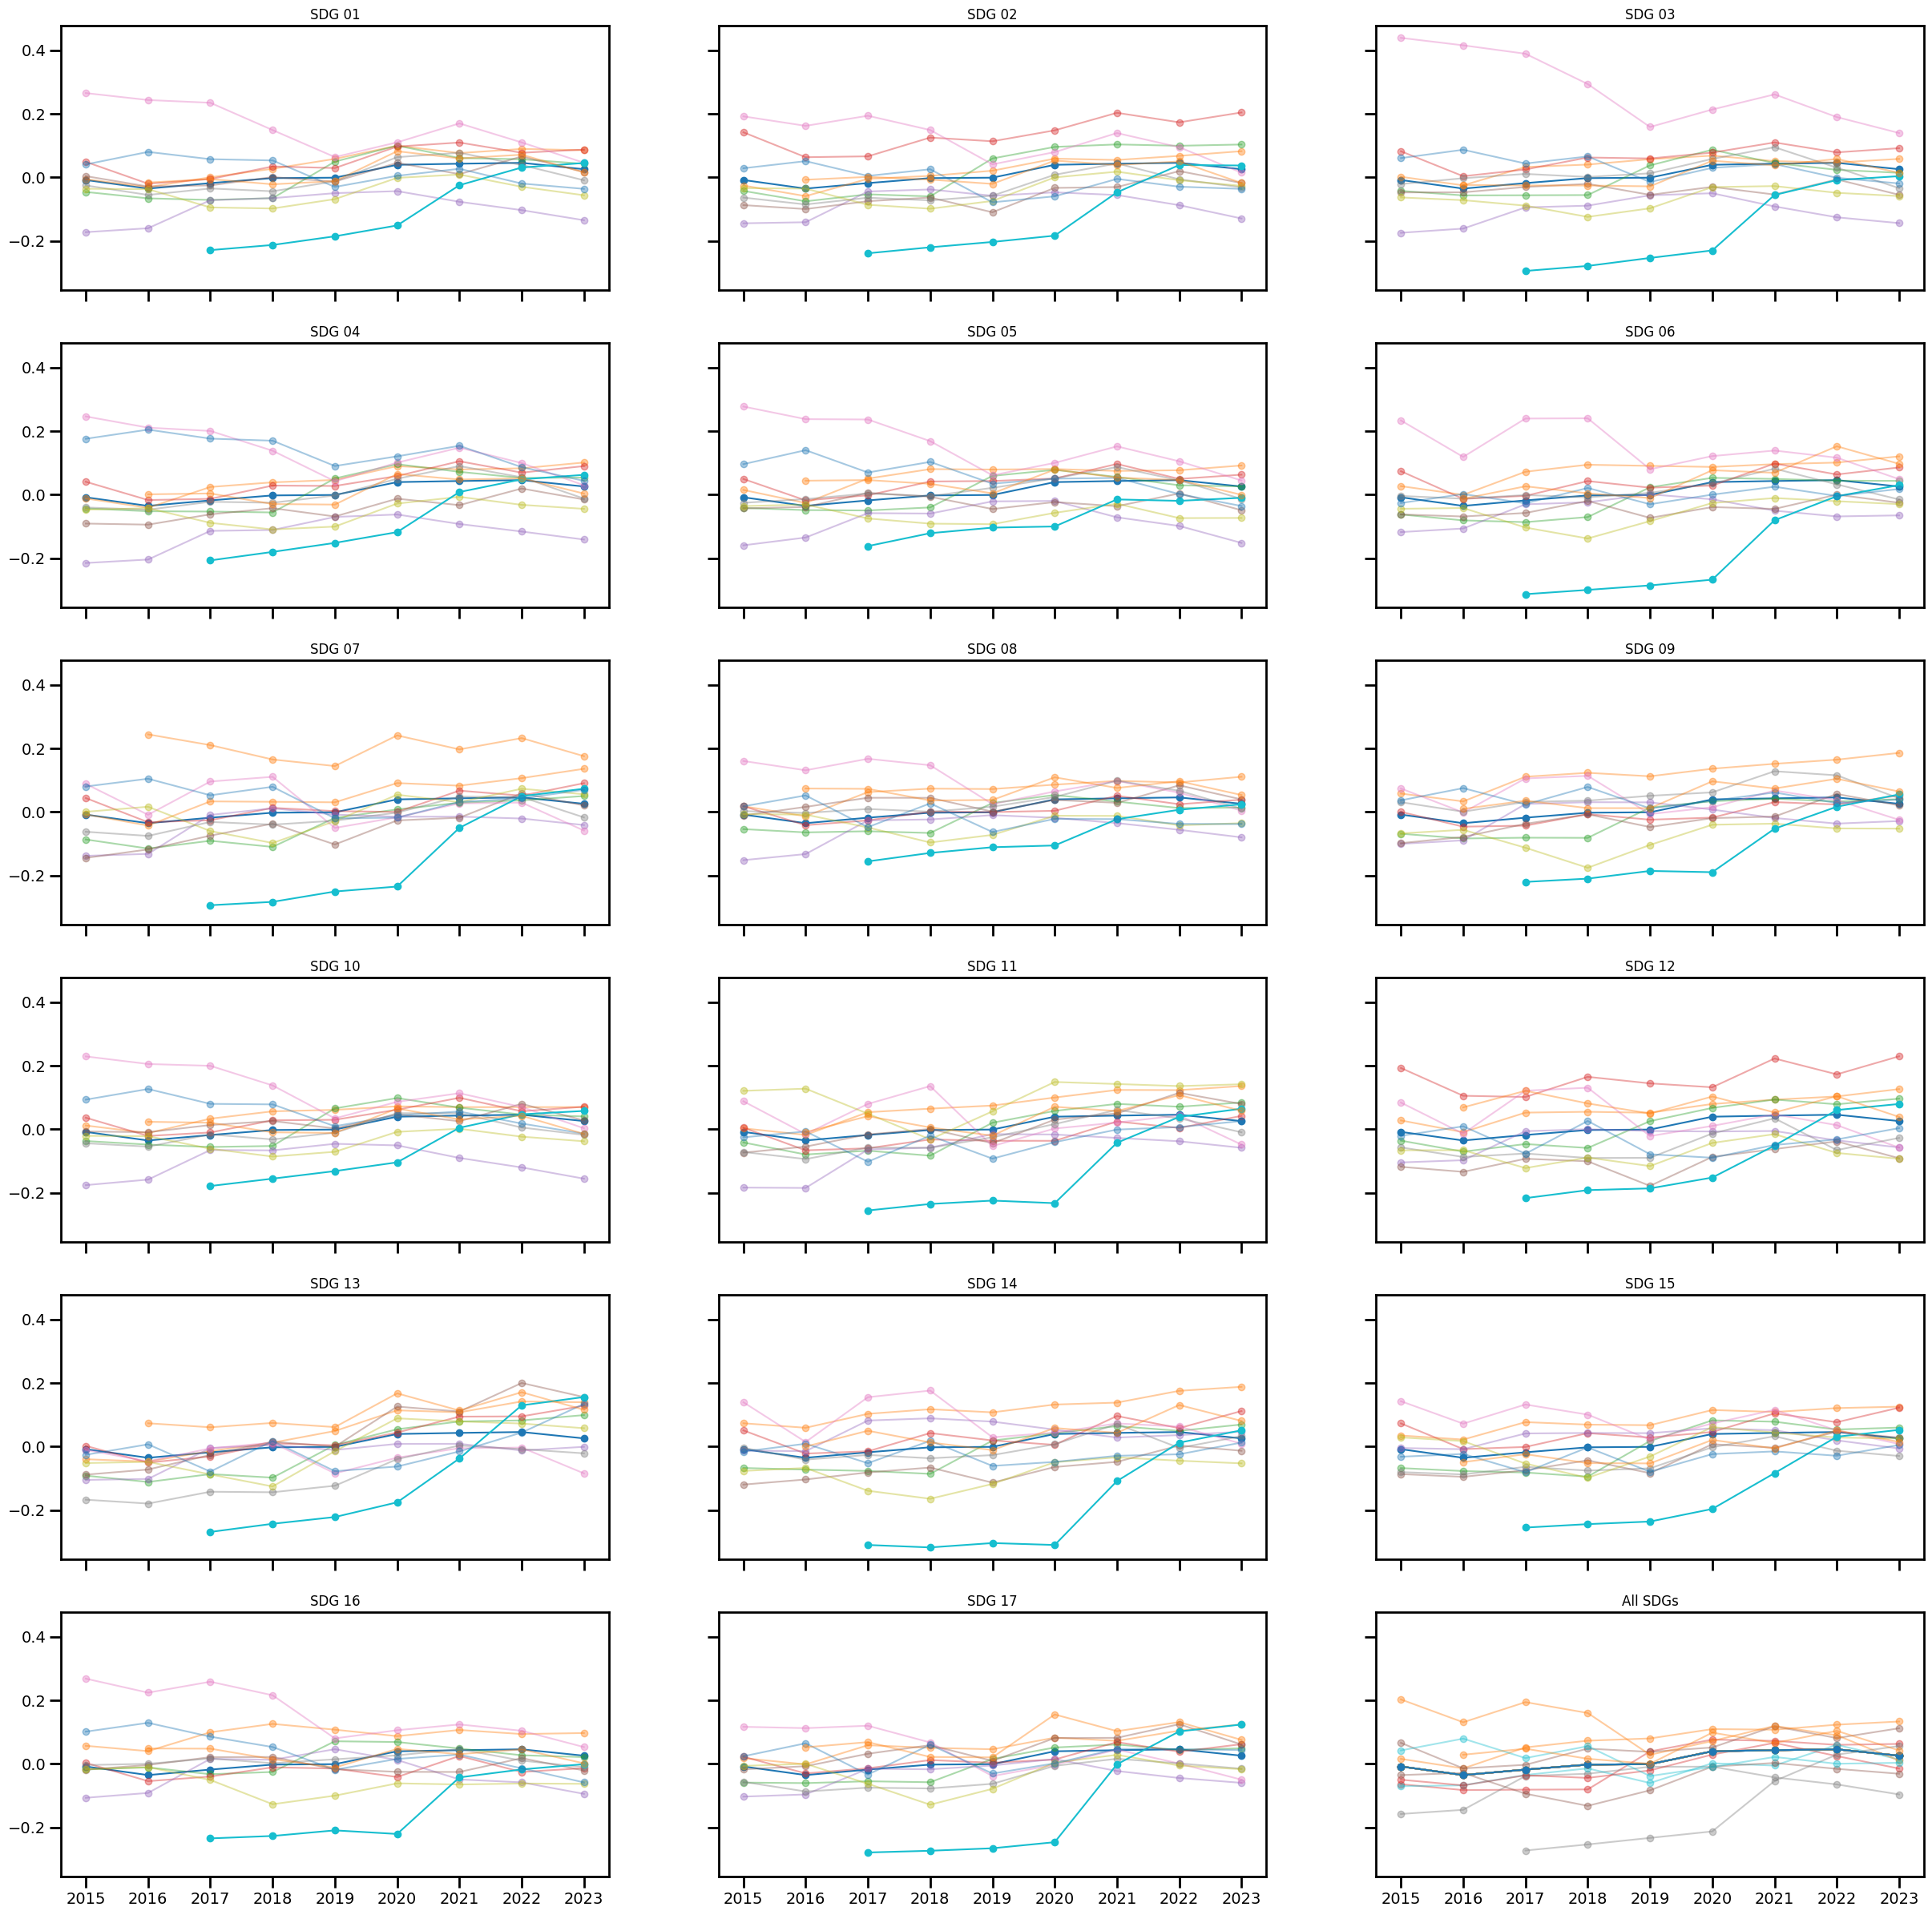

In [349]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        if sec=='09':
            axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
        else:
            axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec, alpha=0.4)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
for sec in secs:
    axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
    axs[5,2].set_title('All SDGs')

plt.show()

# Internal similarity

## Global trend

In [312]:
int_sim={}
for year in tqdm(years):
    _selection=vectors[vectors['year']==year]
    l_sel=len(_selection)
    counter=0
    l_entries=int(l_sel*(l_sel-1)/2)
    int_sim[year]=np.zeros(l_entries)
    for i in range(l_sel):
        for j in range(i+1, l_sel):
            int_sim[year][counter]=float(util.cos_sim(_selection[i]['vector'], _selection[j]['vector']))
            counter+=1
            

  0%|          | 0/9 [00:00<?, ?it/s]

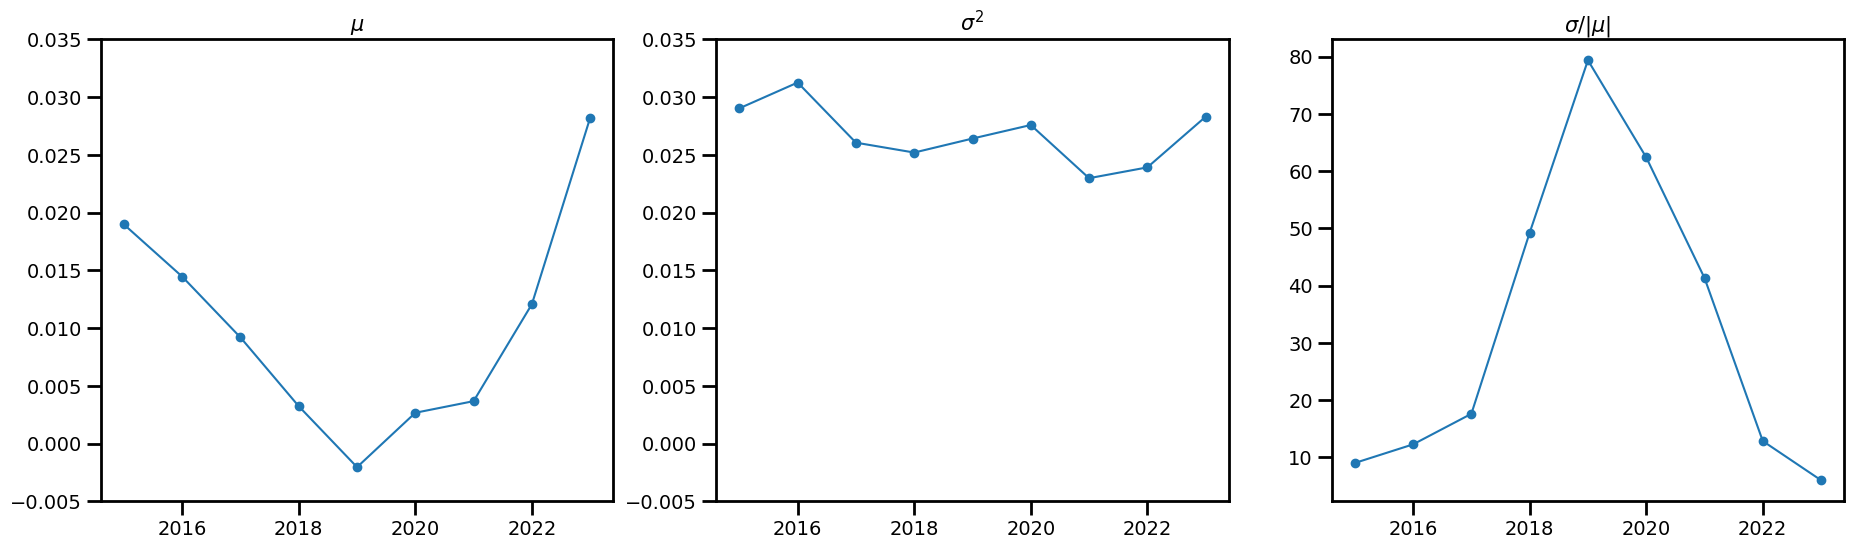

In [438]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 6))
axs[0].plot(np.arange(2015, 2024), [np.mean(int_sim[year]) for year in years], marker='o')
axs[0].set_title(r'$\mu$', fontsize=15)
axs[0].set_ylim(-0.005, 0.035)
axs[1].plot(np.arange(2015, 2024), [np.var(int_sim[year]) for year in years], marker='o')
axs[1].set_title(r'$\sigma^2$', fontsize=15)
axs[1].set_ylim(-0.005, 0.035)
axs[2].plot(np.arange(2015, 2024), [np.std(int_sim[year])/np.abs(np.mean(int_sim[year])) for year in years], marker='o')
axs[2].set_title(r'$\sigma/|\mu|$', fontsize=15)

plt.show()

## Global MK

### Mean

In [317]:
mk.original_test([np.mean(int_sim[year]) for year in years])

Mann_Kendall_Test(trend='no trend', h=False, p=0.9169652366288645, z=-0.10425720702853739, Tau=-0.05555555555555555, s=-2.0, var_s=92.0, slope=-0.00033926611333860864, intercept=0.010537228071398959)

In [324]:
years[:5]

array([2015, 2016, 2017, 2018, 2019], dtype=int32)

In [321]:
mk.original_test([np.mean(int_sim[year]) for year in years[:5]])

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0274863361115103, z=-2.2045407685048604, Tau=-1.0, s=-10.0, var_s=16.666666666666668, slope=-0.005268910381301027, intercept=0.019717984380646578)

In [325]:
years[4:]

array([2019, 2020, 2021, 2022, 2023], dtype=int32)

In [323]:
mk.original_test([np.mean(int_sim[year]) for year in years[4:]])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0274863361115103, z=2.2045407685048604, Tau=1.0, s=10.0, var_s=16.666666666666668, slope=0.0061351773394081165, intercept=-0.008602945450382125)

### Variance

In [336]:
mk.original_test([np.var(int_sim[year]) for year in years])

Mann_Kendall_Test(trend='no trend', h=False, p=0.34808262363292397, z=-0.9383148632568366, Tau=-0.2777777777777778, s=-10.0, var_s=92.0, slope=-0.0005412577880533053, intercept=0.028567912594355843)

In [337]:
years[:5]

array([2015, 2016, 2017, 2018, 2019], dtype=int32)

In [338]:
mk.original_test([np.var(int_sim[year]) for year in years[:5]])

Mann_Kendall_Test(trend='no trend', h=False, p=0.4624327264504764, z=-0.7348469228349533, Tau=-0.4, s=-4.0, var_s=16.666666666666668, slope=-0.0010665474618958798, intercept=0.02853597636593438)

In [339]:
years[4:]

array([2019, 2020, 2021, 2022, 2023], dtype=int32)

In [340]:
mk.original_test([np.var(int_sim[year]) for year in years[4:]])

Mann_Kendall_Test(trend='no trend', h=False, p=0.80649594050734, z=0.2449489742783178, Tau=0.2, s=2.0, var_s=16.666666666666668, slope=0.0003555577612318485, intercept=0.025691765919678925)

## Trend by sector

In [350]:
int_sim_by_sec={}
for sec in secs:
    int_sim_by_sec[sec]={}
    for year in tqdm(years):
        _selection=vectors[np.logical_and(vectors['year']==year,vectors['sector']==sec)]
        l_sel=len(_selection)
        counter=0
        l_entries=int(l_sel*(l_sel-1)/2)
        int_sim_by_sec[sec][year]=np.zeros(l_entries)
        for i in range(l_sel):
            for j in range(i+1, l_sel):
                int_sim_by_sec[sec][year][counter]=float(util.cos_sim(_selection[i]['vector'], _selection[j]['vector']))
                counter+=1
            

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [502]:
def couples2n(a):
    '''
    Given the number of couples, it returns the number of single elements
    '''
    return int((1+np.sqrt(1+8*a))/2)

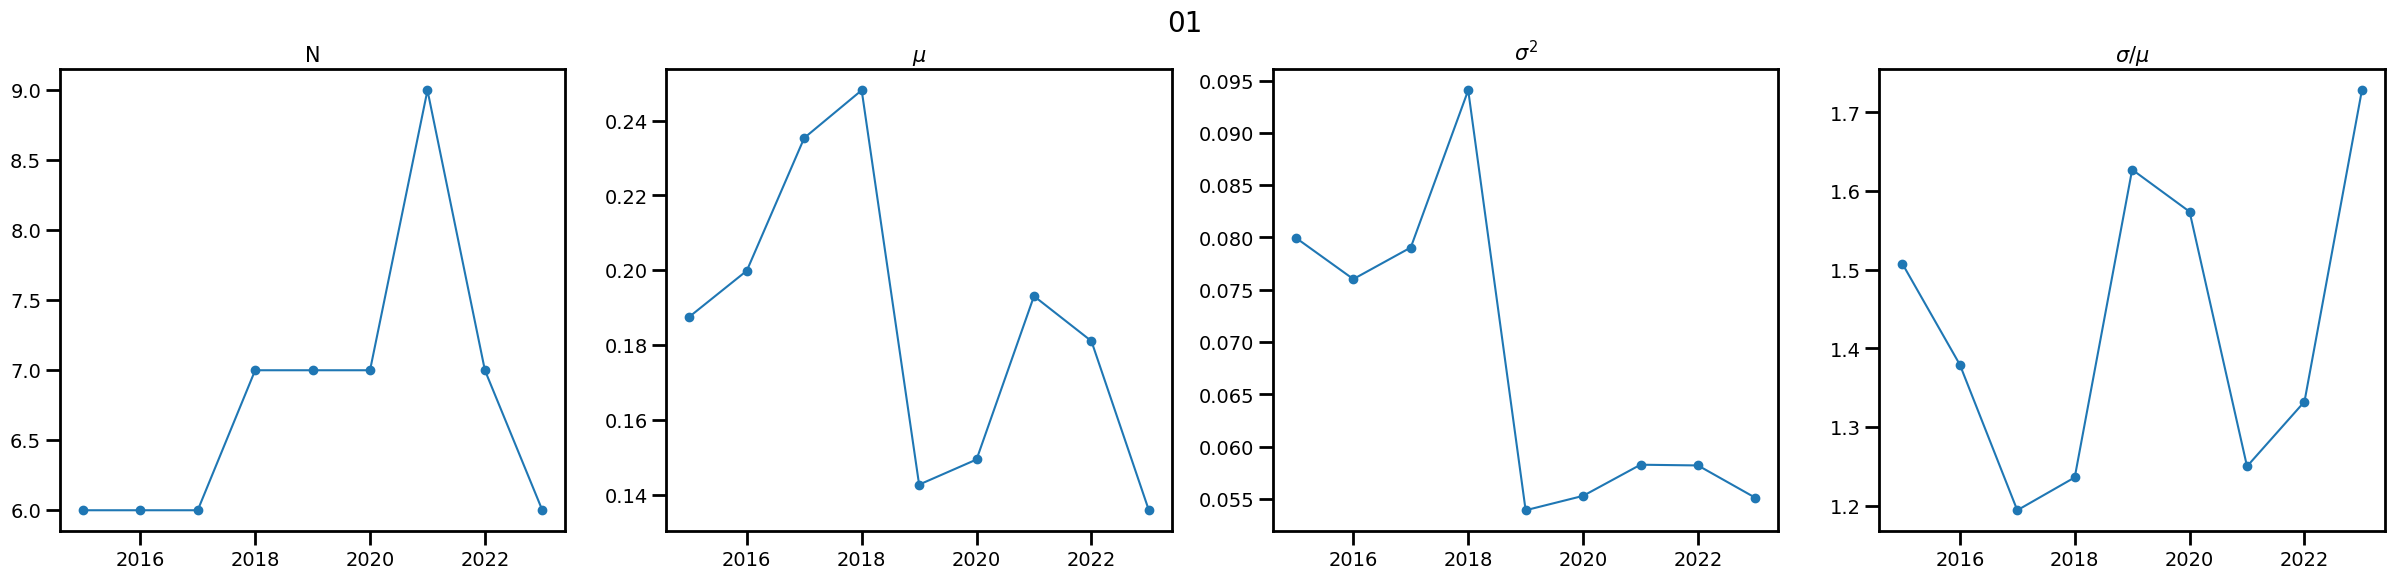

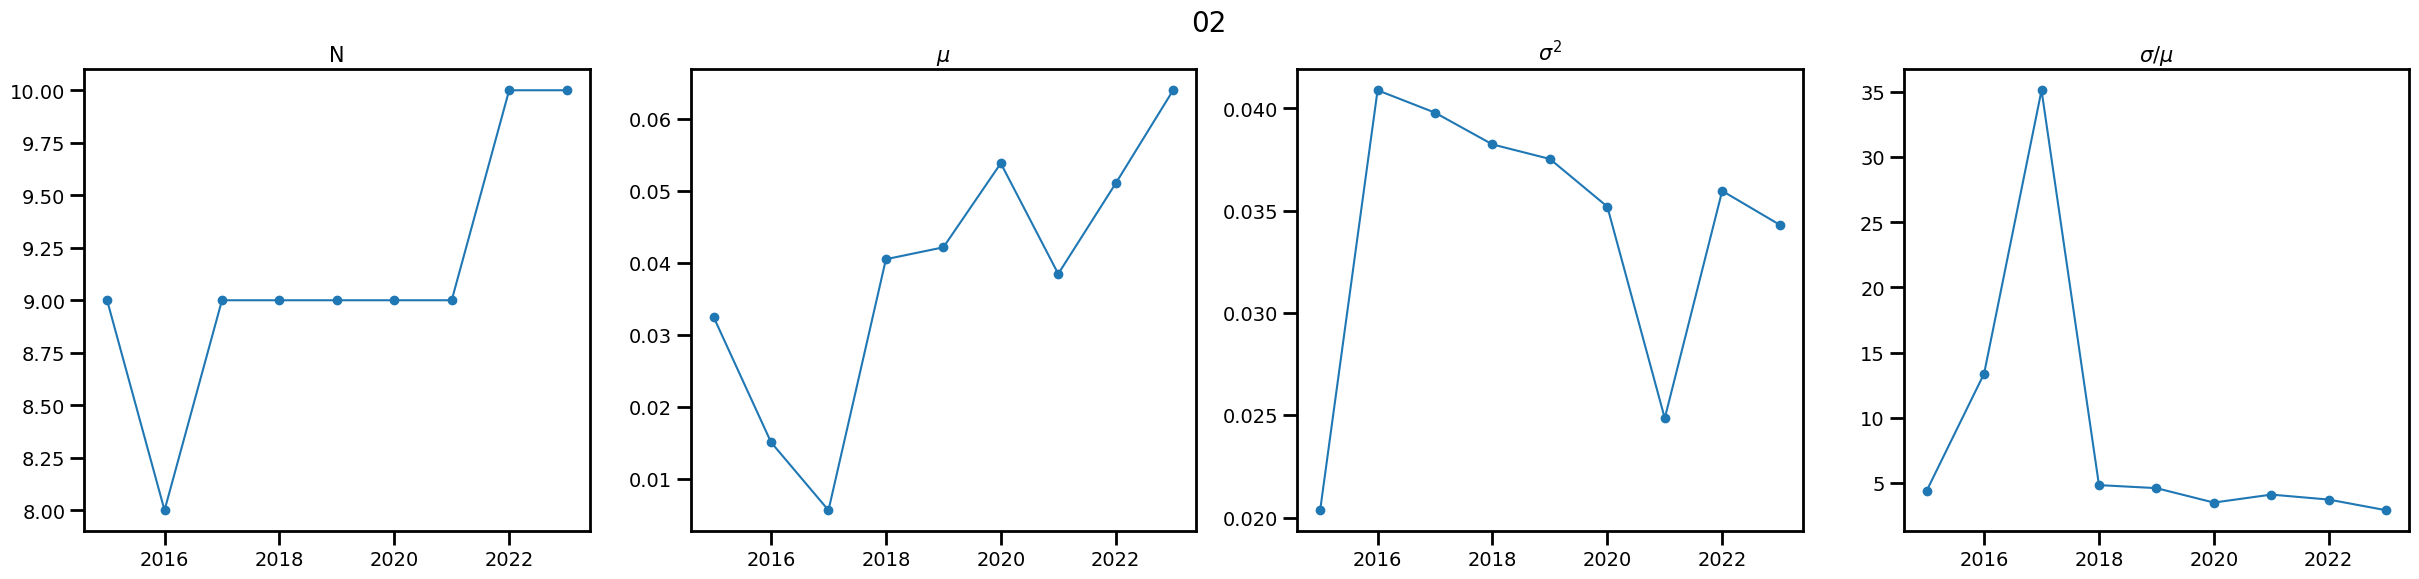

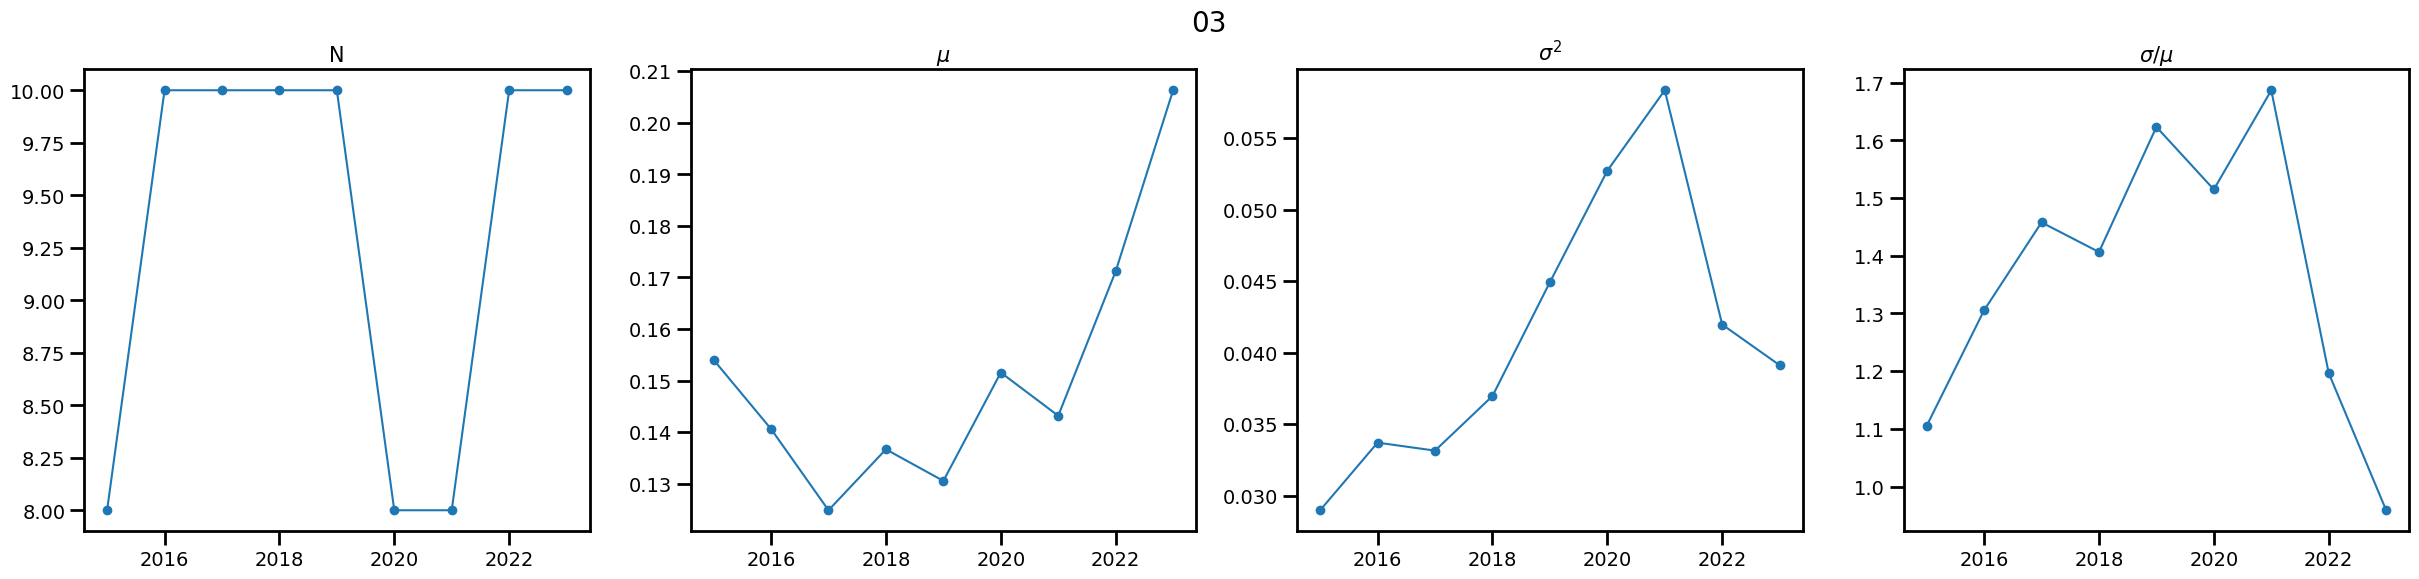

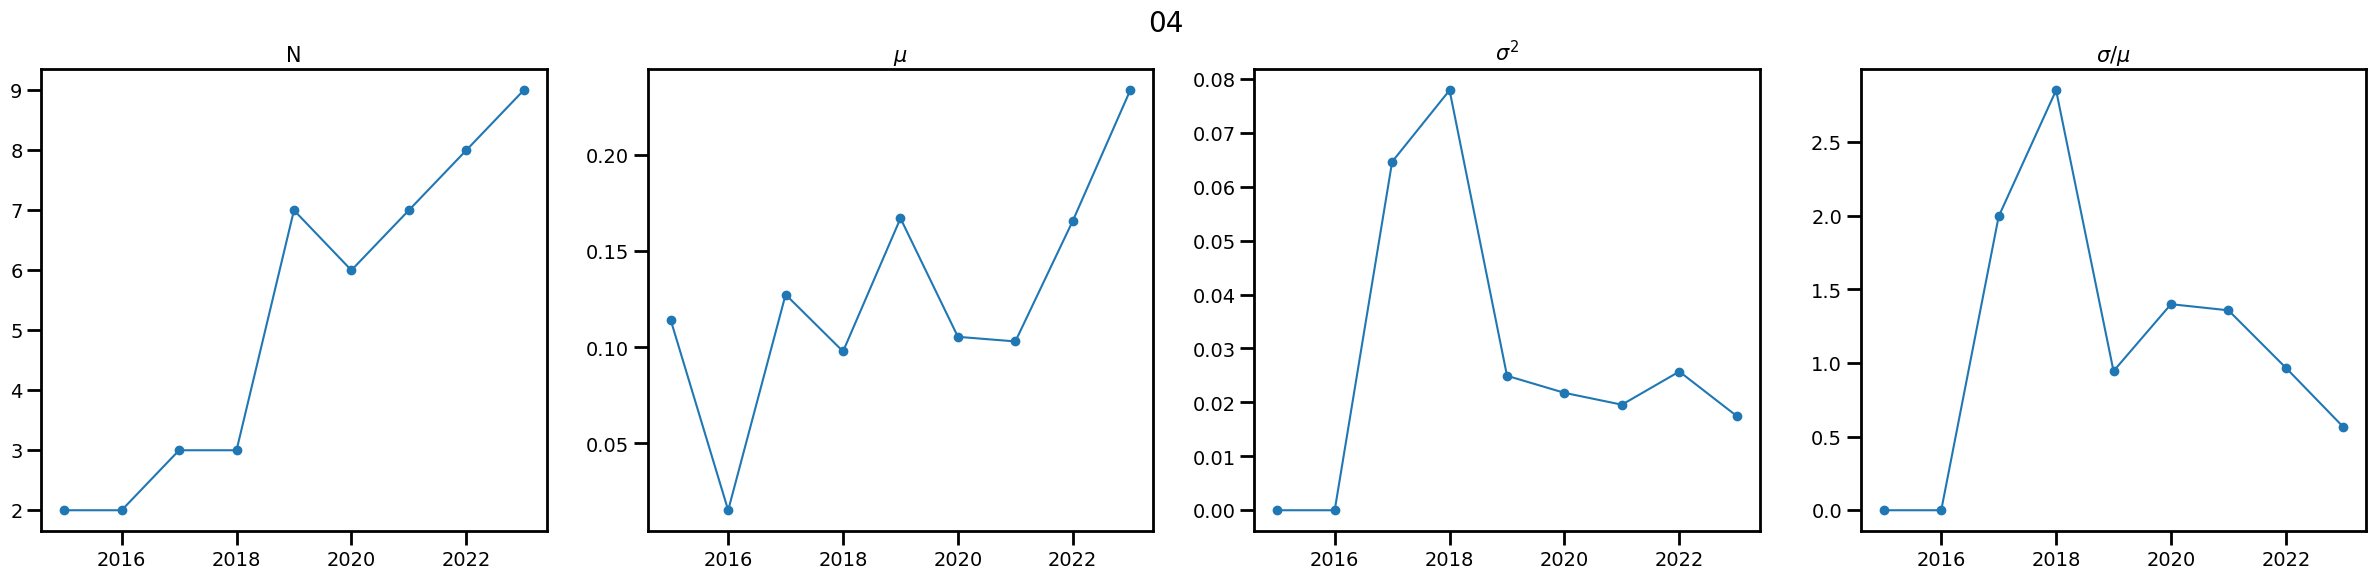

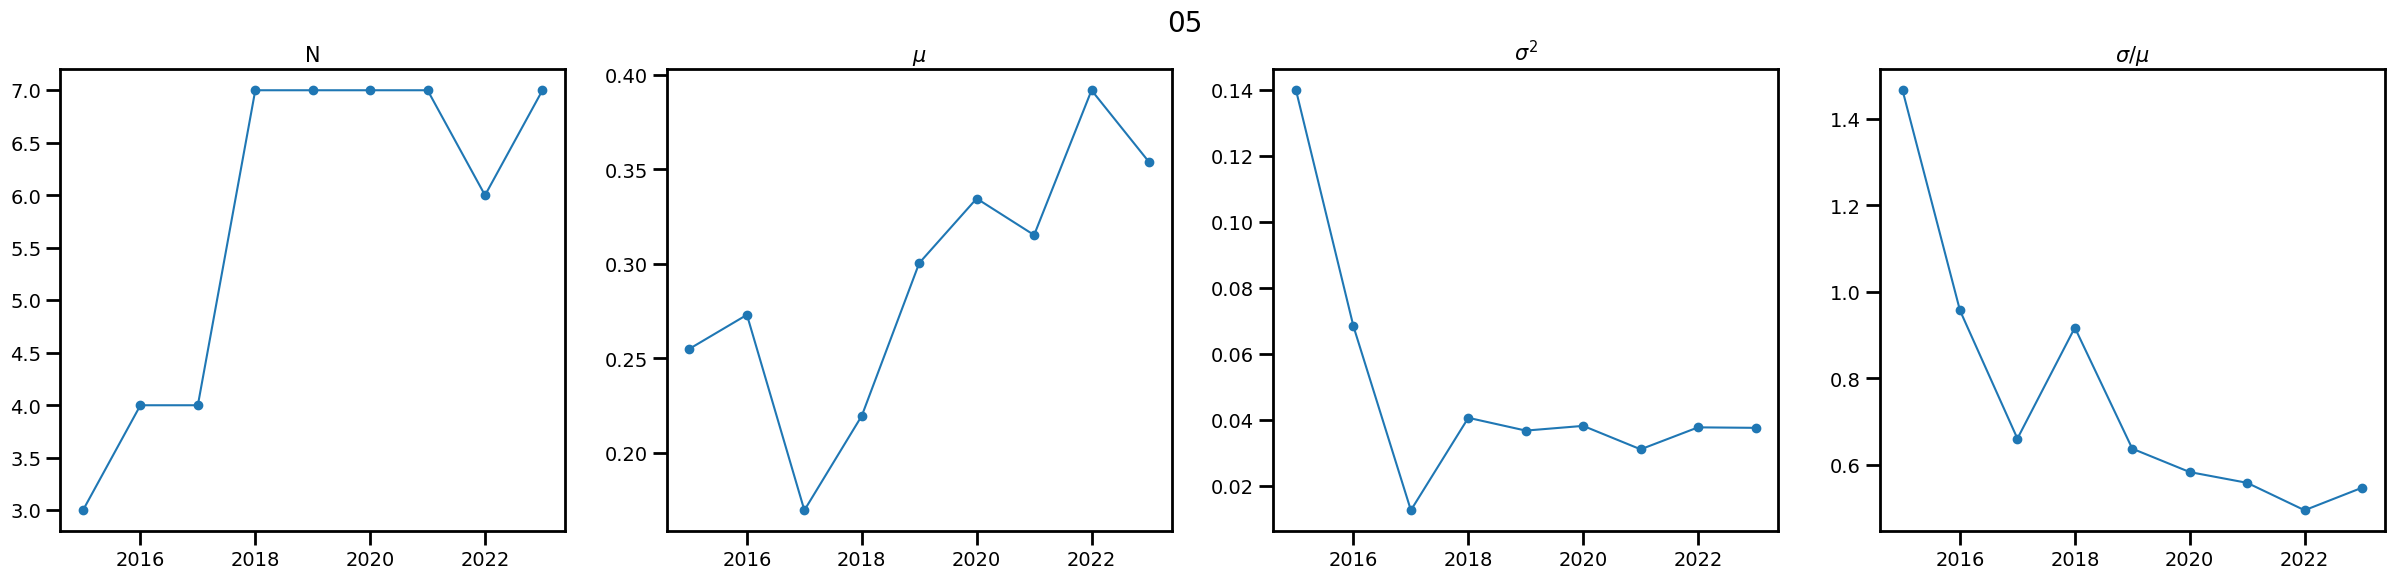

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:269: 

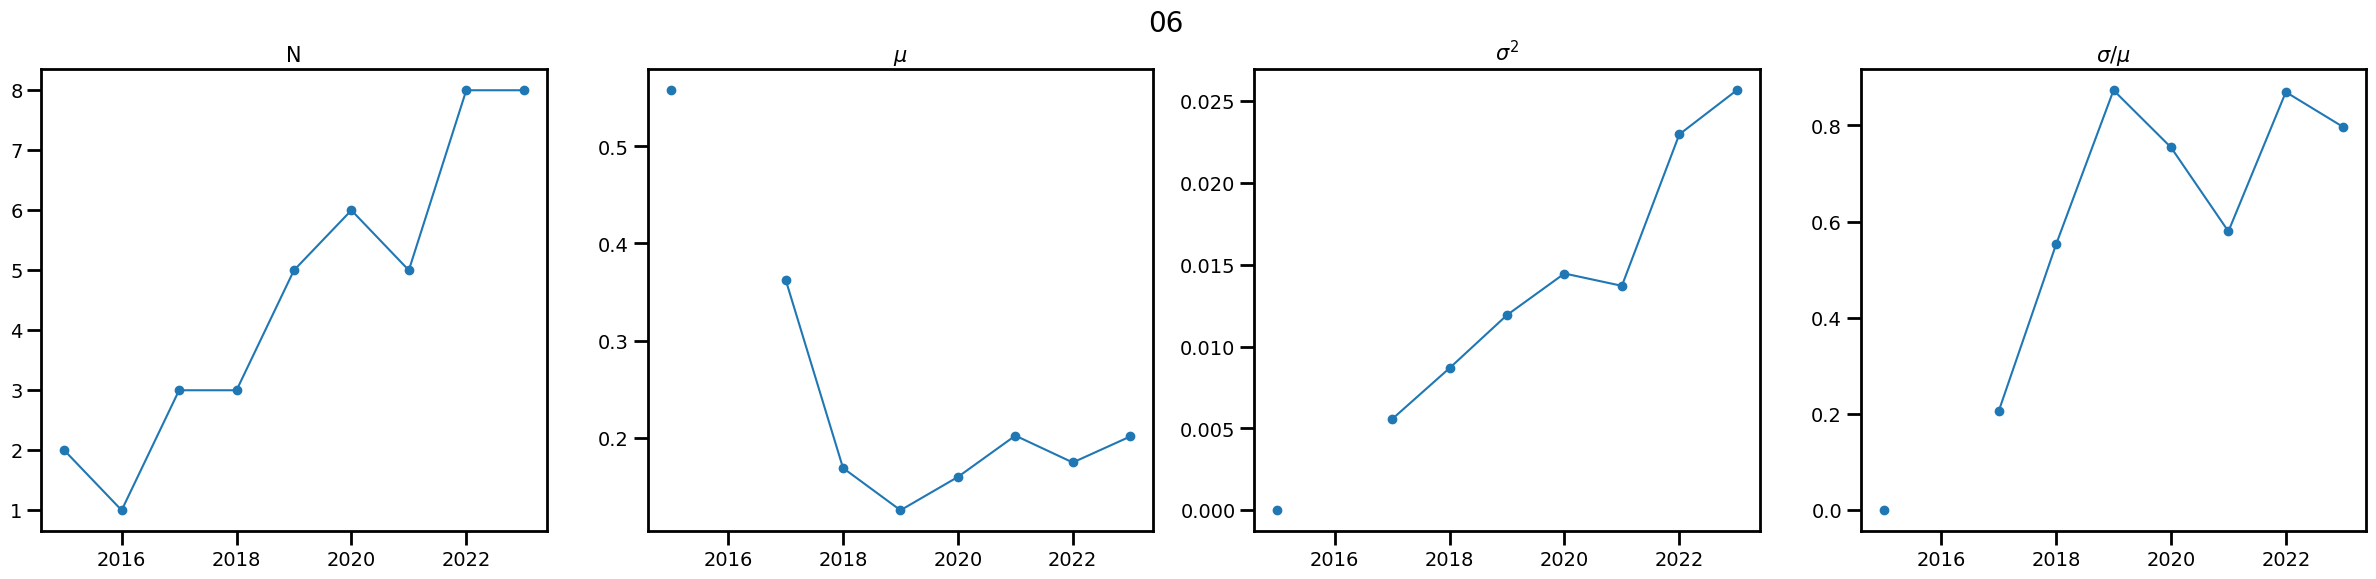

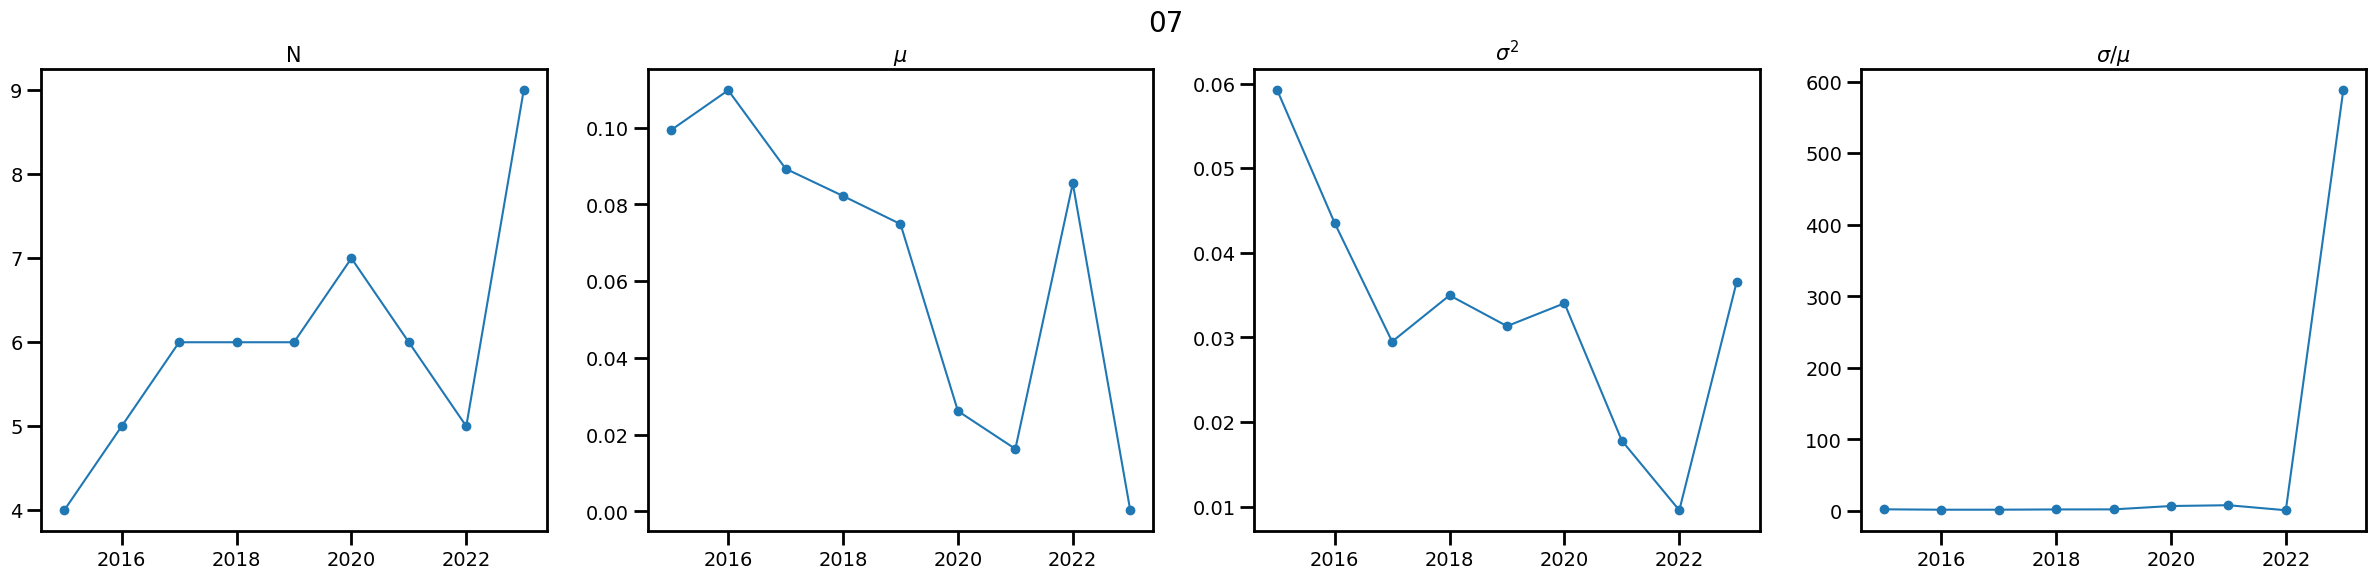

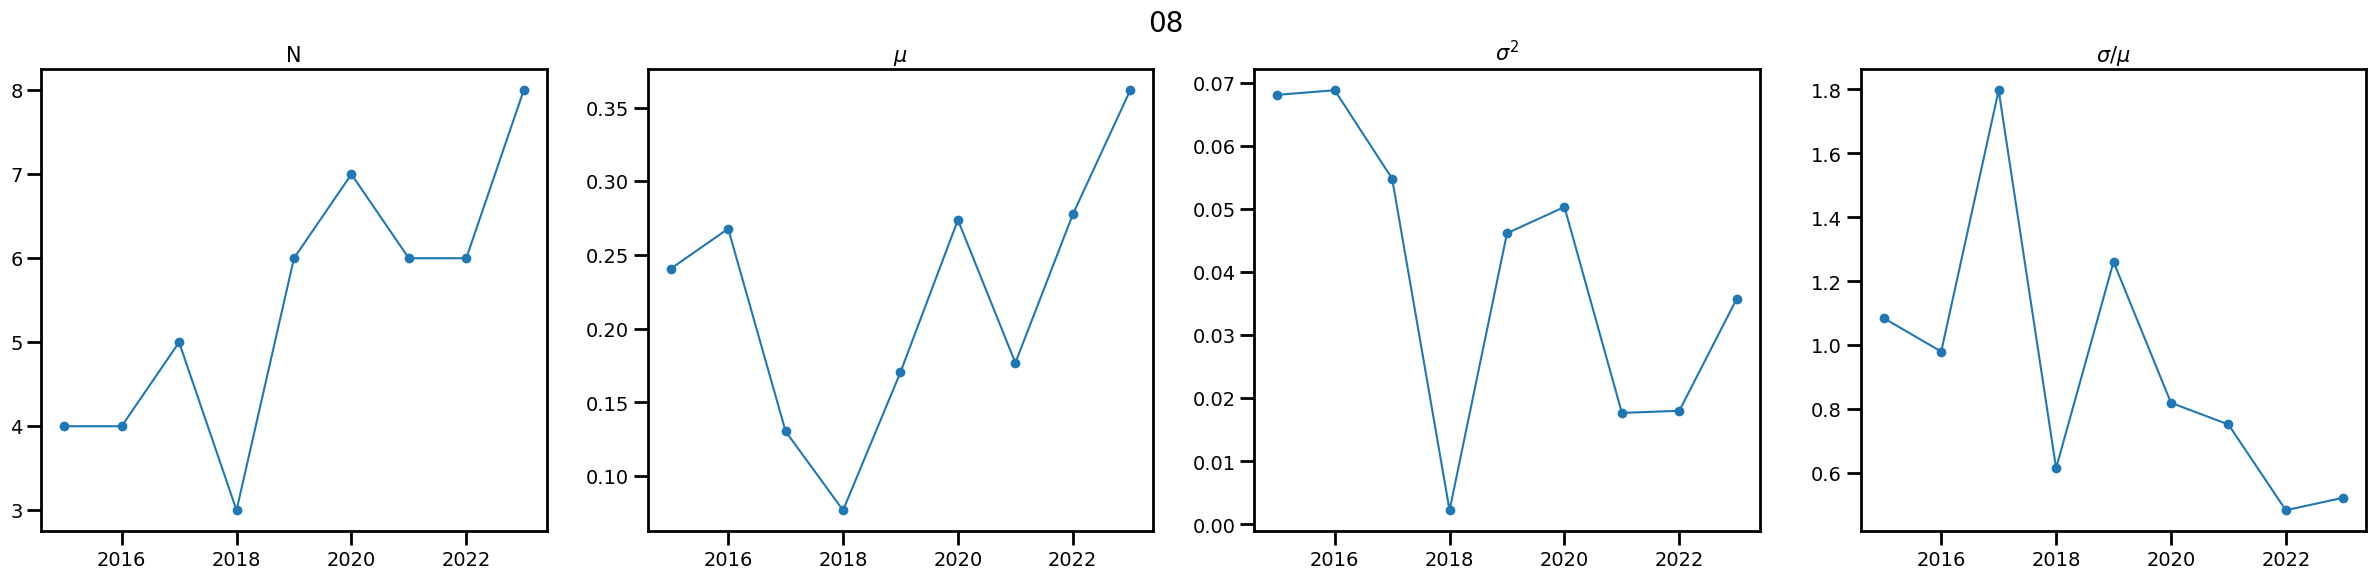

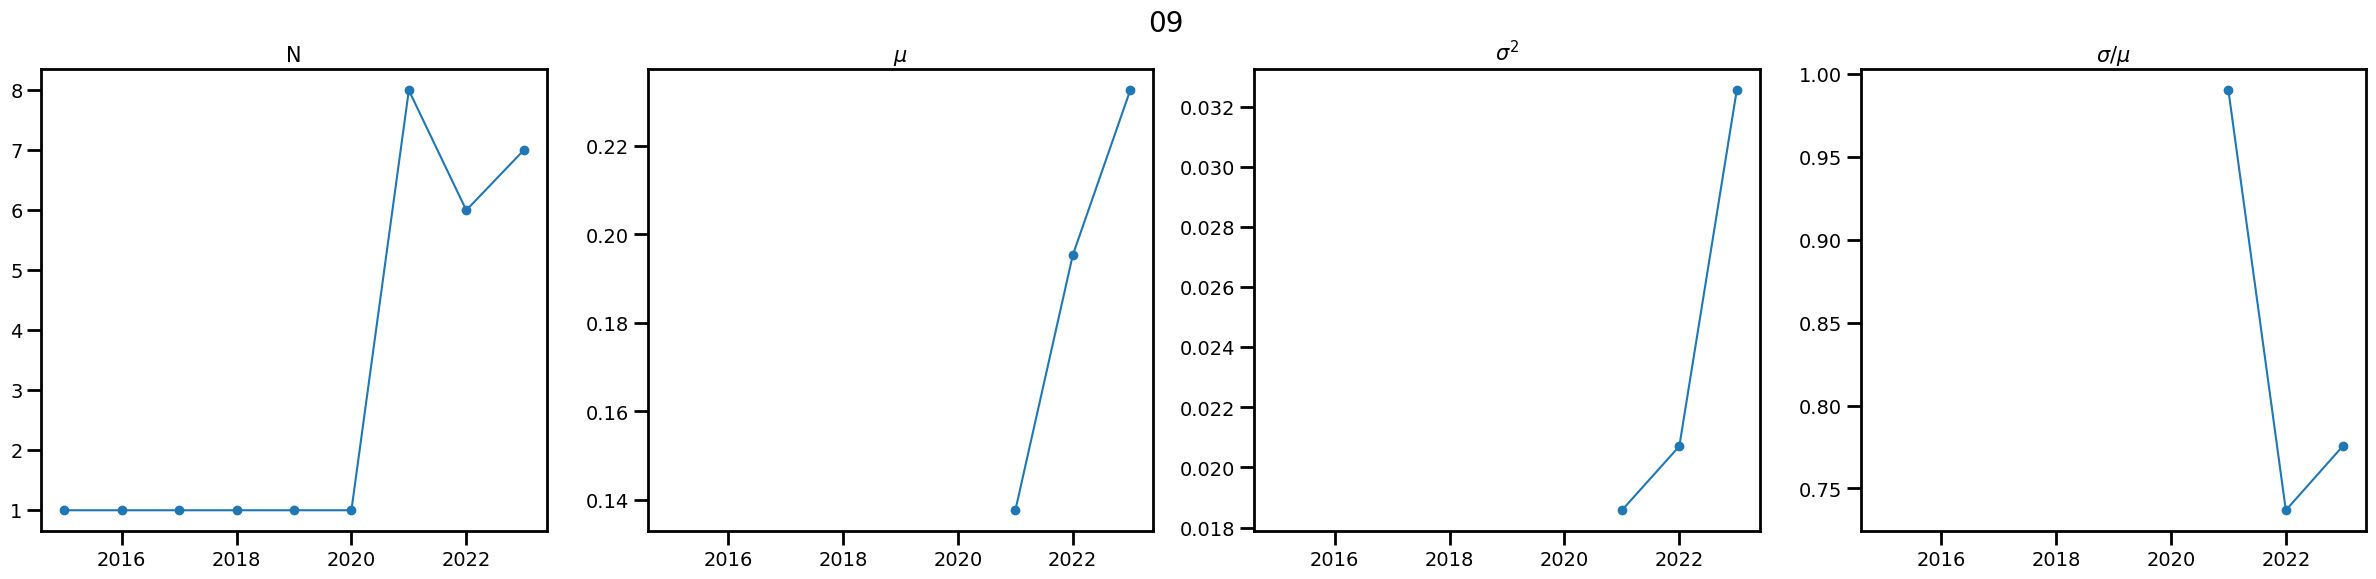

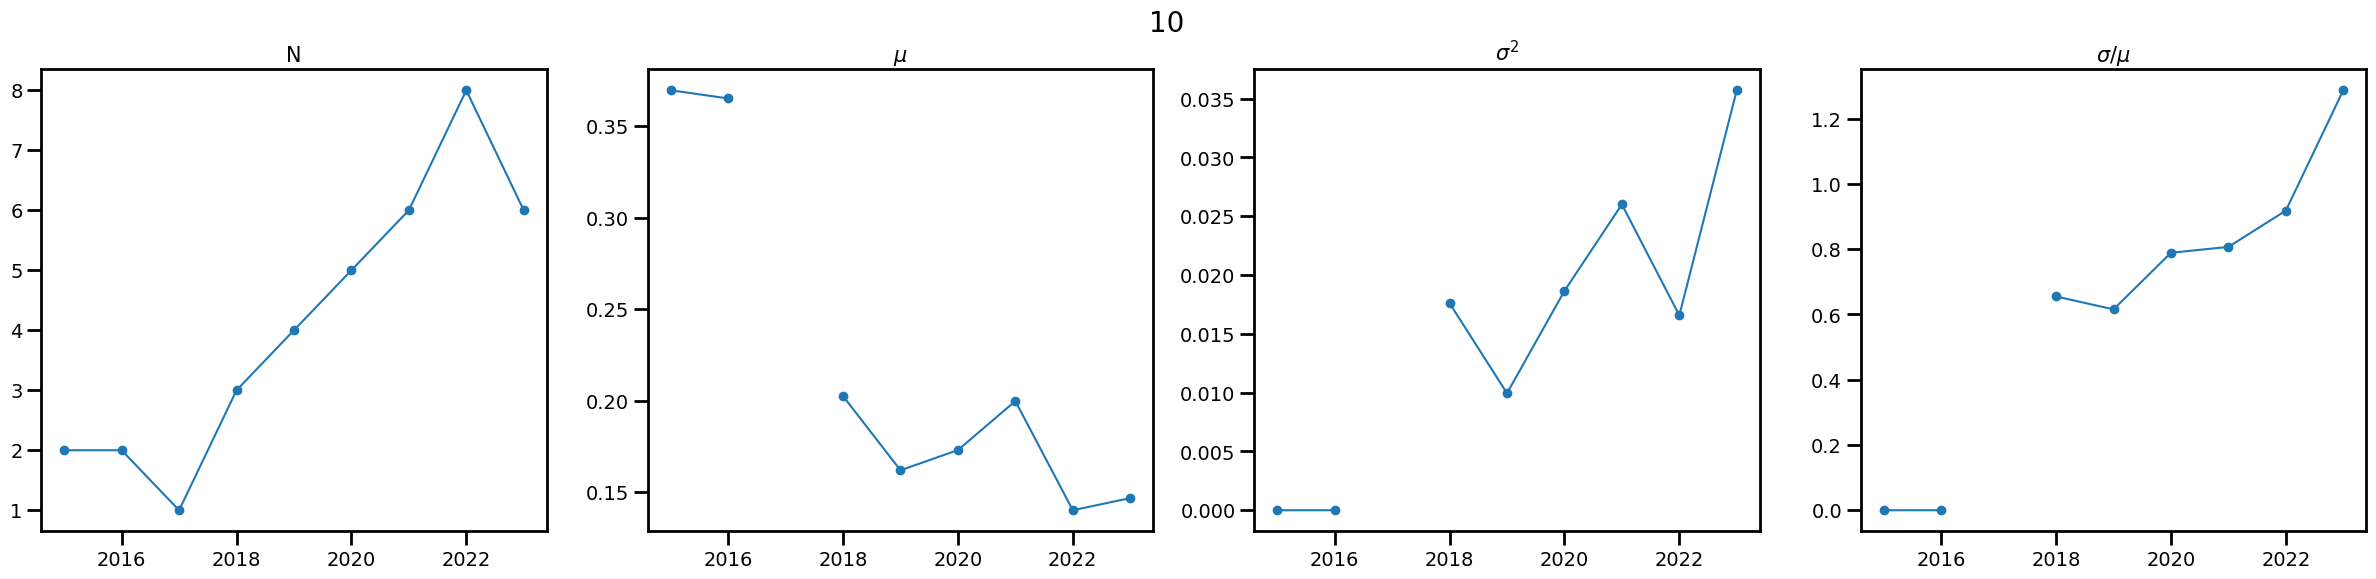

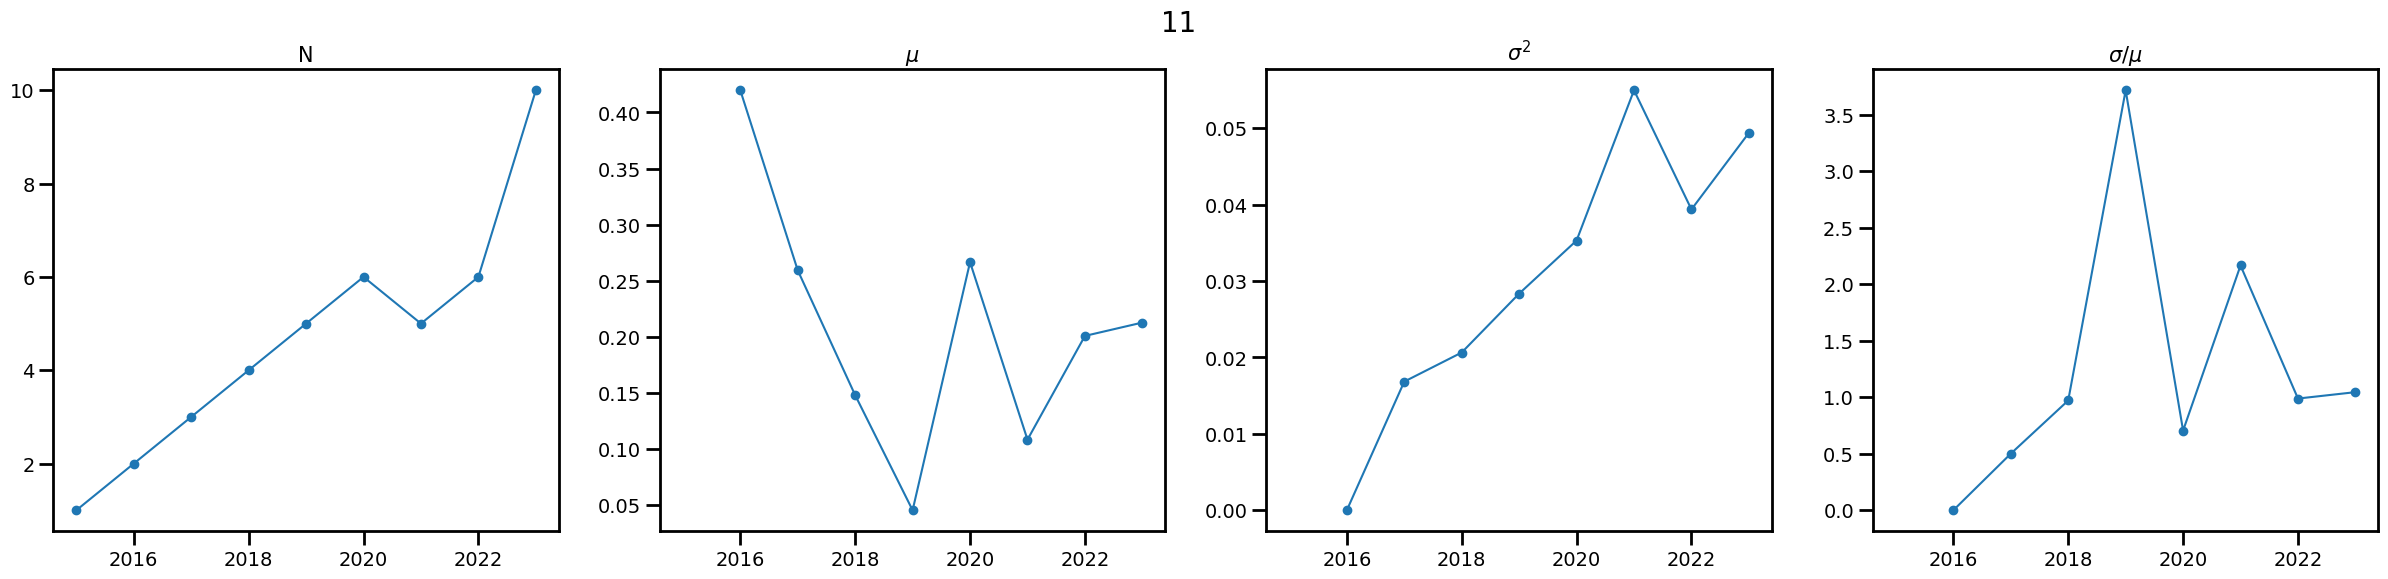

In [474]:
for sec in secs:
    fig, axs=plt.subplots(1, 4, sharex=True, figsize=(30, 6))
    plt.suptitle(sec, fontsize=20)
    axs[0].plot(list(int_sim_by_sec[sec].keys()), [couples2n(len(int_sim_by_sec[sec][year])) for year in years], marker='o')
    axs[0].set_title(r'N', fontsize=15)
    axs[1].plot(list(int_sim_by_sec[sec].keys()), [np.mean(int_sim_by_sec[sec][year]) for year in years], marker='o')
    axs[1].set_title(r'$\mu$', fontsize=15)
    axs[2].plot(list(int_sim_by_sec[sec].keys()), [np.var(int_sim_by_sec[sec][year]) for year in years], marker='o')
    axs[2].set_title(r'$\sigma^2$', fontsize=15)
    axs[3].plot(list(int_sim_by_sec[sec].keys()), [np.std(int_sim_by_sec[sec][year])/np.abs(np.mean(int_sim_by_sec[sec][year])) for year in years], marker='o')
    axs[3].set_title(r'$\sigma/\mu$', fontsize=15)
    plt.show()

Some sectors are two small to carry any information, let's consider only the greatest ones. 

In [481]:
reliable_th=5

In [482]:
reliable_secs=[]
for sec in secs:
    if all([couples2n(len(int_sim_by_sec[sec][year]))>=reliable_th for year in years]):
        reliable_secs.append(sec)

In [483]:
[(rs, sec_helper[rs]) for rs in reliable_secs]

[('01', 'Basic Materials'),
 ('02', 'Consumer Discretionary'),
 ('03', 'Consumer Staples')]

## MK by sector

In [384]:
for sec in reliable_secs:
    _mk=mk.original_test([np.mean(int_sim_by_sec[sec][year]) for year in years])
    if not _mk.h:
        print(f'{sec:}) {sec_helper[sec]:22}: {_mk.trend:}')
    else:
        print(f'{sec:}) {sec_helper[sec]:22}: {_mk.trend:}, p-value={_mk.p:.2e}, slope={_mk.slope:.2e}')

01) Basic Materials       : no trend
02) Consumer Discretionary: increasing, p-value=2.86e-02, slope=4.68e-03
03) Consumer Staples      : no trend


## Going back

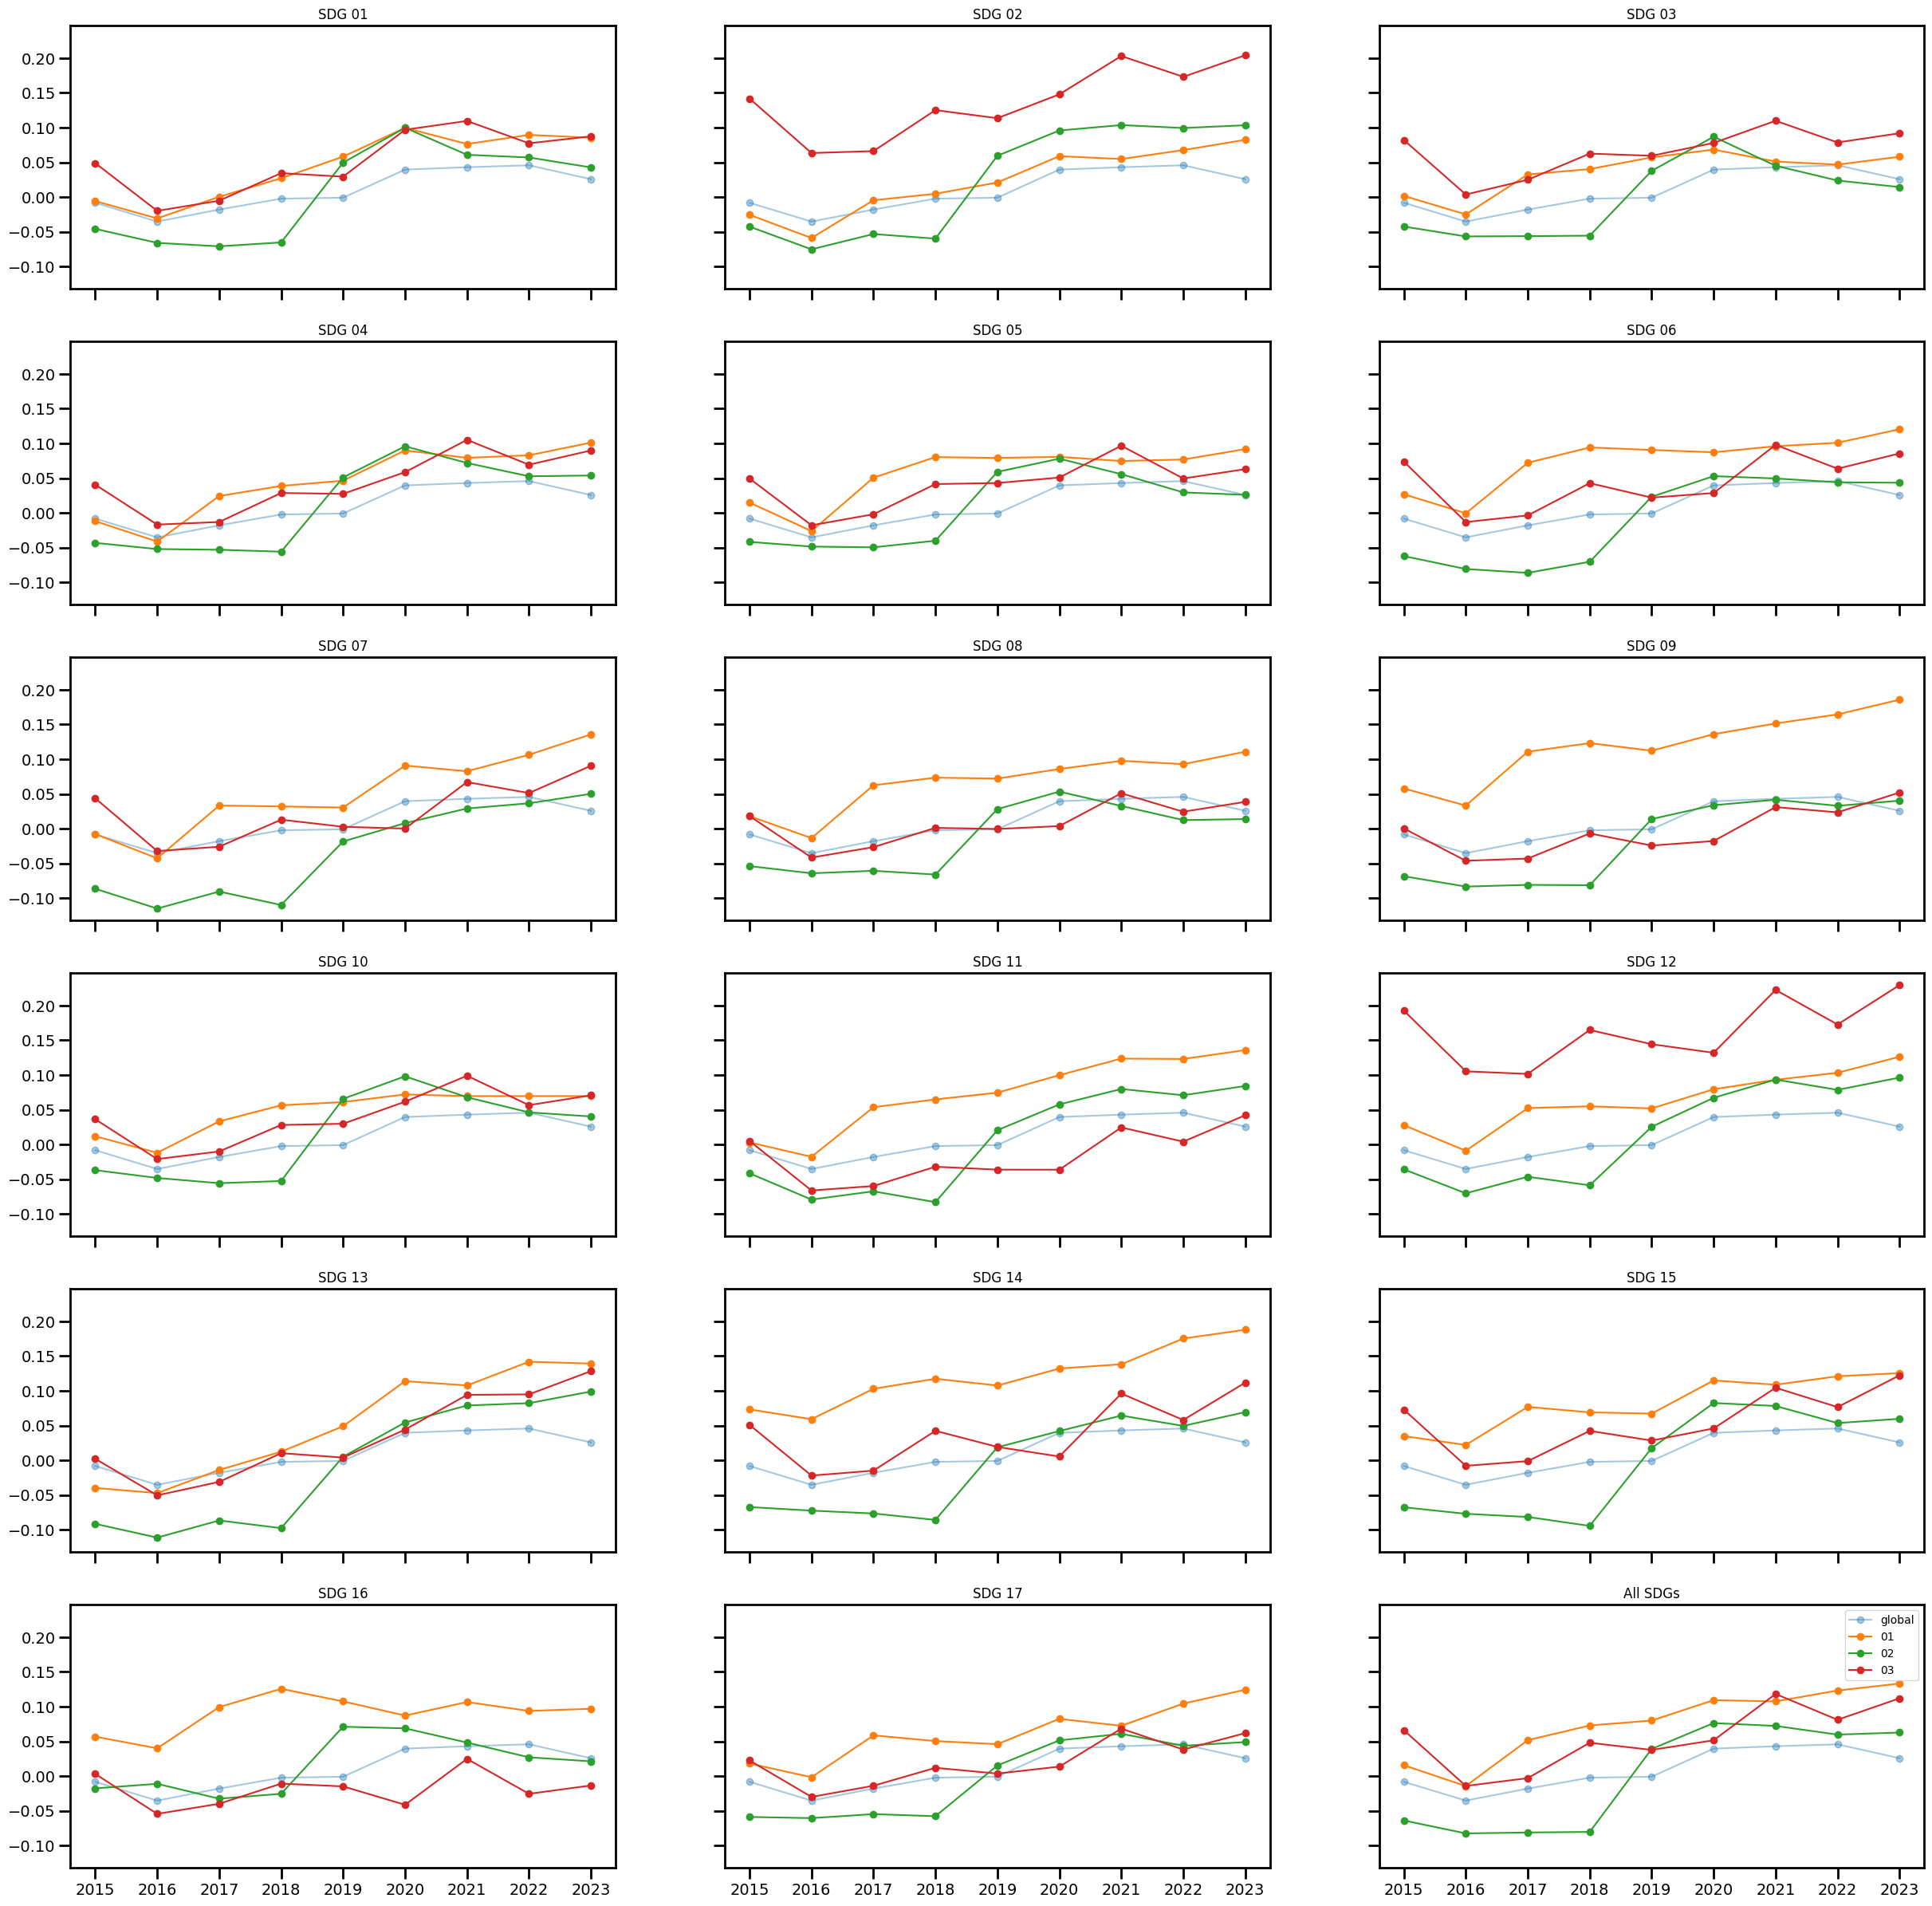

In [393]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global', alpha=0.4)
    for sec in reliable_secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global', alpha=0.4)
for sec in reliable_secs:
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec)
    axs[5,2].set_title('All SDGs')
axs[5,2].legend()

plt.show()

In [400]:
for sdg in sdgs:
    print(f'\nSDG{sdg:}\t{sdg_helper[sdg]:}\n---------------')
    for sec in reliable_secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        cacca=mk.original_test(_selection['mean'])
        print(f'{sec:}) {sec_helper[sec]:22}: \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')


SDG01	No Poverty
---------------
01) Basic Materials       : increasing, p-value=9.15e-03, slope=1.58e-02
02) Consumer Discretionary: no trend  , p-value=1.75e-01, slope=1.67e-02
03) Consumer Staples      : no trend  , p-value=7.63e-02, slope=1.46e-02

SDG02	Zero hunger
---------------
01) Basic Materials       : increasing, p-value=1.23e-03, slope=1.51e-02
02) Consumer Discretionary: increasing, p-value=1.65e-02, slope=2.50e-02
03) Consumer Staples      : increasing, p-value=1.65e-02, slope=1.85e-02

SDG03	Good health and well-being
---------------
01) Basic Materials       : increasing, p-value=2.86e-02, slope=8.00e-03
02) Consumer Discretionary: no trend  , p-value=1.75e-01, slope=1.10e-02
03) Consumer Staples      : no trend  , p-value=7.63e-02, slope=9.43e-03

SDG04	Quality education
---------------
01) Basic Materials       : increasing, p-value=2.50e-03, slope=1.43e-02
02) Consumer Discretionary: no trend  , p-value=1.75e-01, slope=1.63e-02
03) Consumer Staples      : increasin

# Clustering SDGs

In [403]:
social_sdgs=['01','02','03','04','05','10','16','17']
economic_sdgs=['07','08','09','11','12']
environmental_sdgs=['06','13','14','15']

## Mean vectors

In [408]:
[goalvecfile for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in social_sdgs])]

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt']

In [416]:
social_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in social_sdgs])]
social_vec=np.mean(social_vec, axis=0)

In [417]:
economic_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in economic_sdgs])]
economic_vec=np.mean(economic_vec, axis=0)

In [419]:
environmental_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in environmental_sdgs])]
environmental_vec=np.mean(environmental_vec, axis=0)

In [420]:
clustered_sdgs=np.array([social_vec, economic_vec, environmental_vec])

In [422]:
clustered_sdgs.shape

(3, 63)

## Global

In [423]:
cos_sims_global_cluster=np.zeros((3, len(years)), dtype=[('mean', 'f8'), ('all', object)])

In [424]:
for i_y, year in enumerate(tqdm(years)):
    for i_c, cluster in enumerate(['Social', 'Economic', 'Environmental']):
    
        cos_sims_global_cluster[i_c, i_y]['all']=np.array([float(util.cos_sim(clustered_sdgs[i_c], vec)) for vec in vectors[vectors['year']==year]['vector']])
        cos_sims_global_cluster[i_c, i_y]['mean']=np.mean(cos_sims_global_cluster[i_c, i_y]['all'])
        

  0%|          | 0/9 [00:00<?, ?it/s]

In [431]:
sdg_sectors=['Social', 'Economic', 'Environmental']

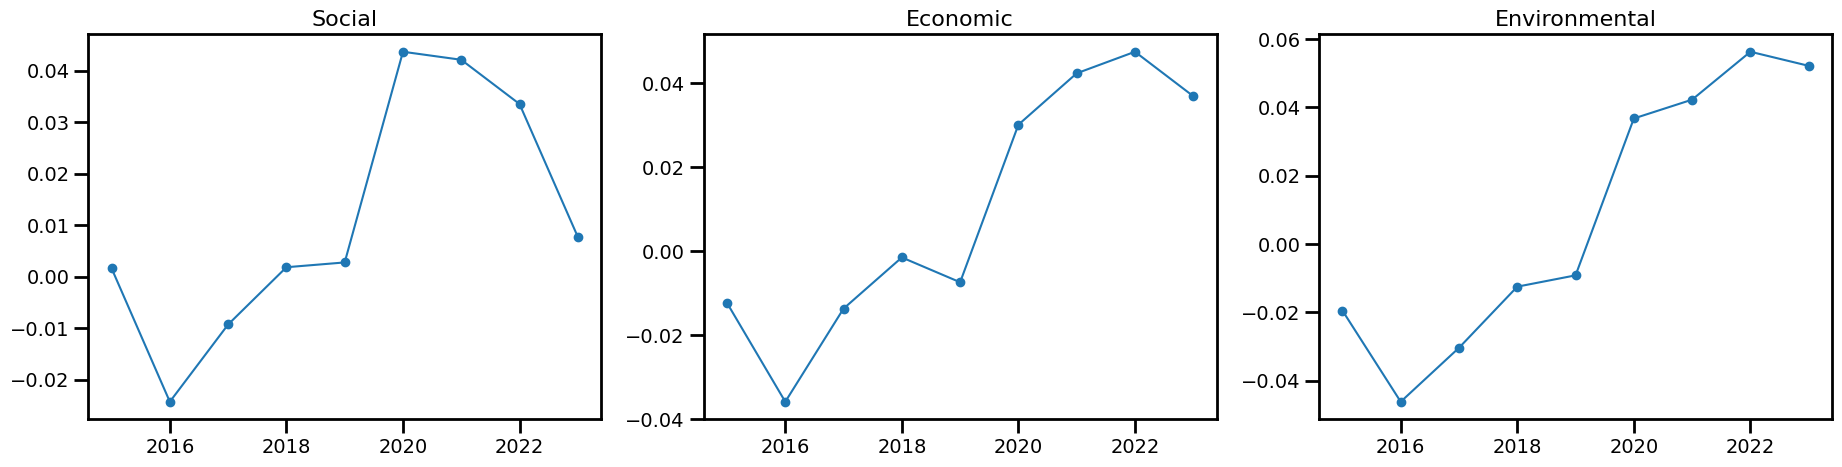

In [432]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 5))
for i_ax, ax in enumerate(axs):
    ax.plot(np.arange(2015, 2024), cos_sims_global_cluster[i_ax]['mean'], marker='o')
    ax.set_title(sdg_sectors[i_ax], fontsize=16)
plt.show()

### MK

In [446]:
for i_c, cluster in enumerate(['Social', 'Economic', 'Environmental']):
    _aux=mk.original_test(cos_sims_global_cluster[i_c,:]['mean'])
    print(f'{cluster:14}) {_aux.trend:}, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')

Social        ) increasing, p-value=4.76e-02, slope=6.39e-03
Economic      ) increasing, p-value=9.15e-03, slope=9.94e-03
Environmental ) increasing, p-value=2.50e-03, slope=1.39e-02


## By sector

In [452]:
cos_sims_sec_cluster=np.zeros((3*len(reliable_secs), len(years)), dtype=[('mean', 'f8'), ('all', object)])

In [453]:
for i_y, year in enumerate(tqdm(years)):
    for i_c, cluster in enumerate(sdg_sectors):
        for i_s, sec in enumerate(reliable_secs):
            cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s, i_y]['all']=np.array([float(util.cos_sim(clustered_sdgs[i_c], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
            cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s, i_y]['mean']=np.mean(cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s, i_y]['all'])        

  0%|          | 0/9 [00:00<?, ?it/s]

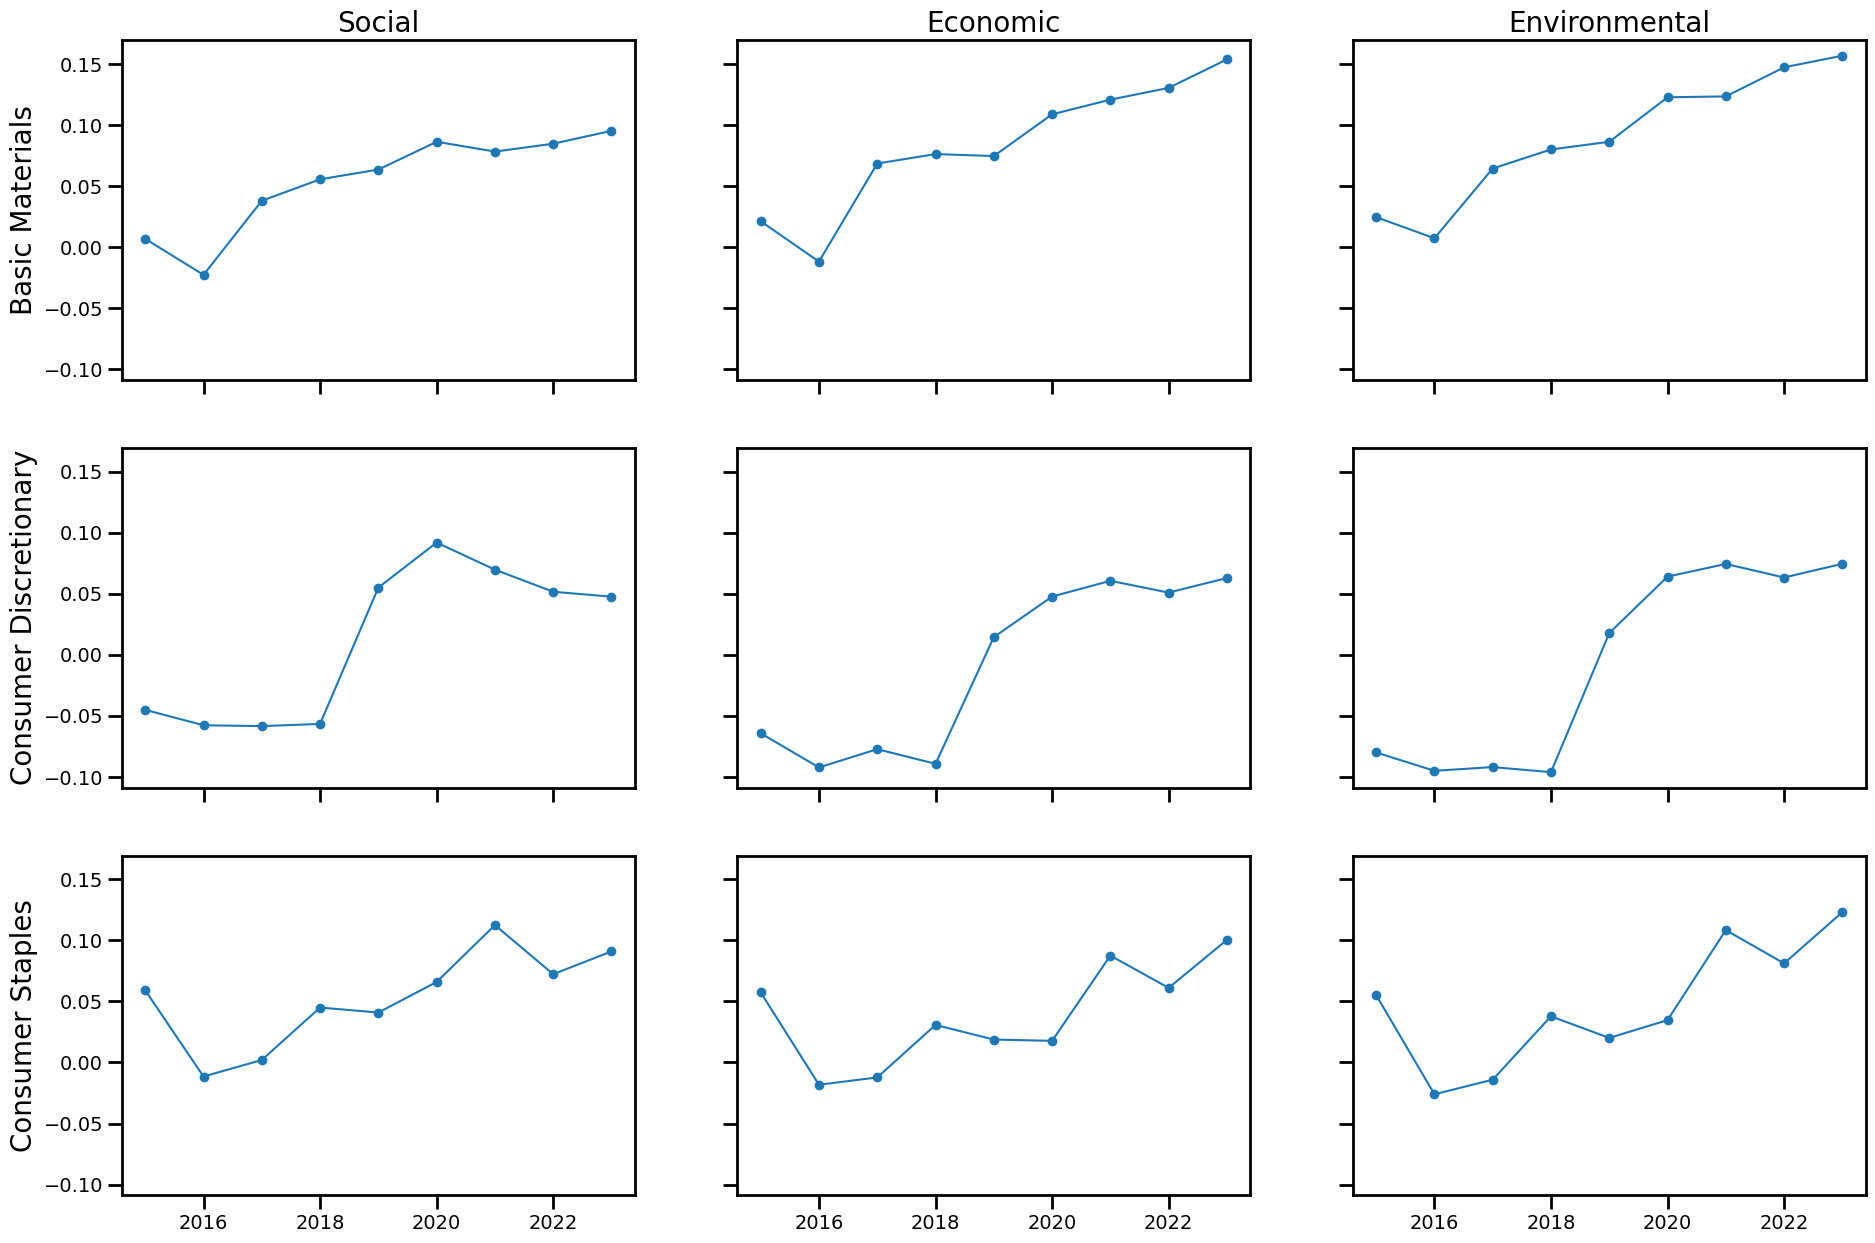

In [495]:
fig, axs=plt.subplots(3, 3, sharex=True, figsize=(22.5, 15), sharey=True)
for i_s, sec in enumerate(reliable_secs):
    for i_c, cluster in enumerate(sdg_sectors):
        _mean=cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s]['mean']
        axs[i_s,i_c].plot(np.arange(2015, 2024), _mean, marker='o')
        if i_s==0:
            axs[i_s,i_c].set_title(sdg_sectors[i_c], fontsize=20)
        if i_c==0:
            axs[i_s,i_c].set_ylabel(sec_helper[sec], fontsize=20)
plt.show()

In [491]:
for i_c, cluster in enumerate(sdg_sectors):
    print(f'\n\033[1m{cluster:}\033[0m')
    for i_s, sec in enumerate(reliable_secs):
        _aux=mk.original_test(cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s]['mean'])
        if _aux.trend!='no trend': 
            print(f'\033[3m{sec_helper[sec]:22}\033[0m \033[1m{_aux.trend:}\033[0m, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')
        else:
            print(f'{sec_helper[sec]:22} {_aux.trend:}, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')


Social
Basic Materials        increasing, p-value=2.50e-03, slope=1.11e-02
Consumer Discretionary no trend, p-value=2.51e-01, slope=1.64e-02
Consumer Staples       increasing, p-value=2.86e-02, slope=1.30e-02

Economic
Basic Materials        increasing, p-value=1.23e-03, slope=1.64e-02
Consumer Discretionary increasing, p-value=9.15e-03, slope=2.15e-02
Consumer Staples       no trend, p-value=7.63e-02, slope=1.28e-02

Environmental
Basic Materials        increasing, p-value=5.81e-04, slope=1.72e-02
Consumer Discretionary increasing, p-value=2.86e-02, slope=2.51e-02
Consumer Staples       increasing, p-value=4.76e-02, slope=1.67e-02


In [492]:
trend_color={'increasing':'green', 'no trend':'orange', 'decreasing':'red'}

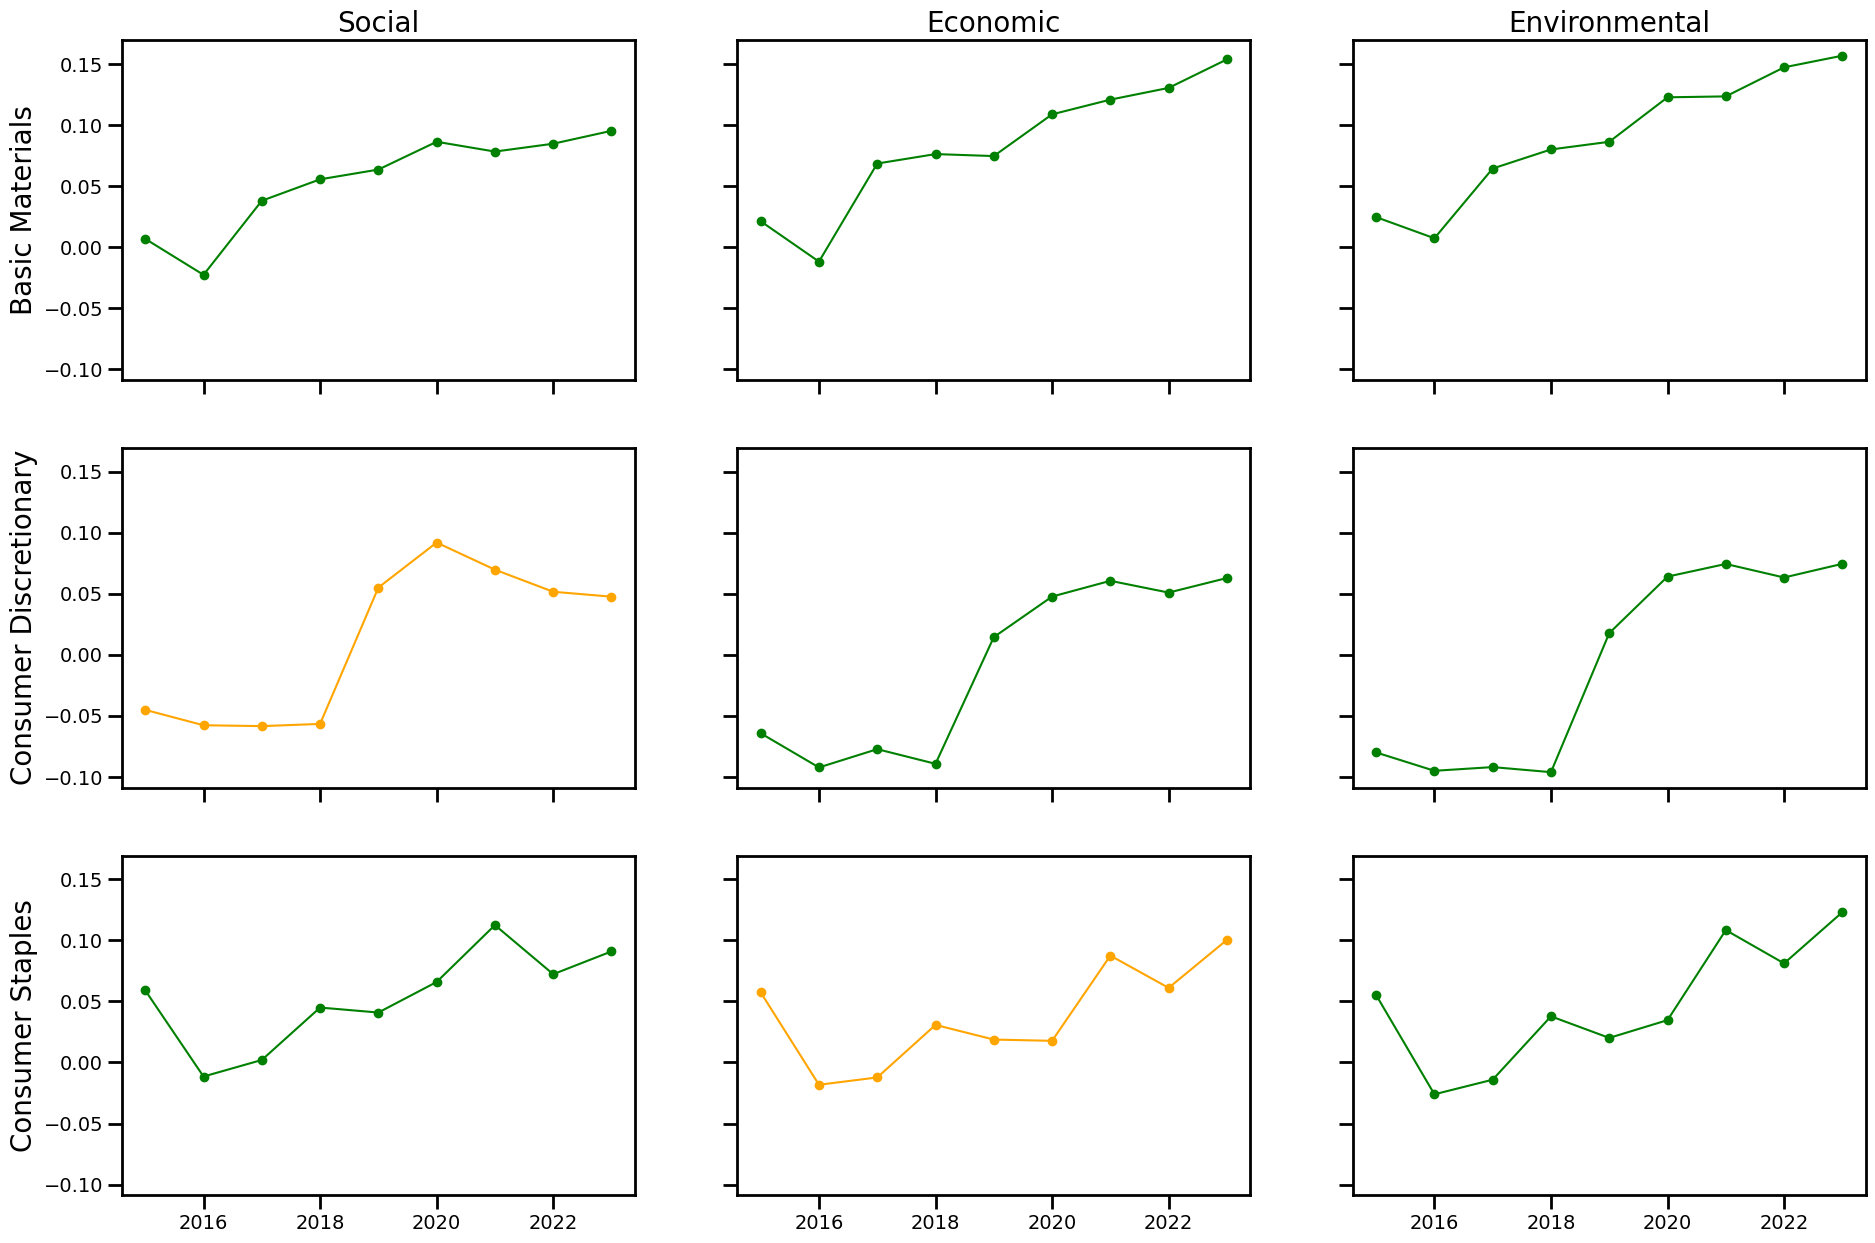

In [496]:
fig, axs=plt.subplots(3, 3, sharex=True, figsize=(22.5, 15), sharey=True)
for i_s, sec in enumerate(reliable_secs):
    for i_c, cluster in enumerate(sdg_sectors):
        _mean=cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s]['mean']
        _aux=mk.original_test(_mean)
        axs[i_s,i_c].plot(np.arange(2015, 2024), _mean, marker='o', c=trend_color[_aux.trend])
        if i_s==0:
            axs[i_s,i_c].set_title(sdg_sectors[i_c], fontsize=20)
        if i_c==0:
            axs[i_s,i_c].set_ylabel(sec_helper[sec], fontsize=20)
plt.show()

In [507]:
markers=['o', 'x', '+']
ls=['-', '--', '-.']

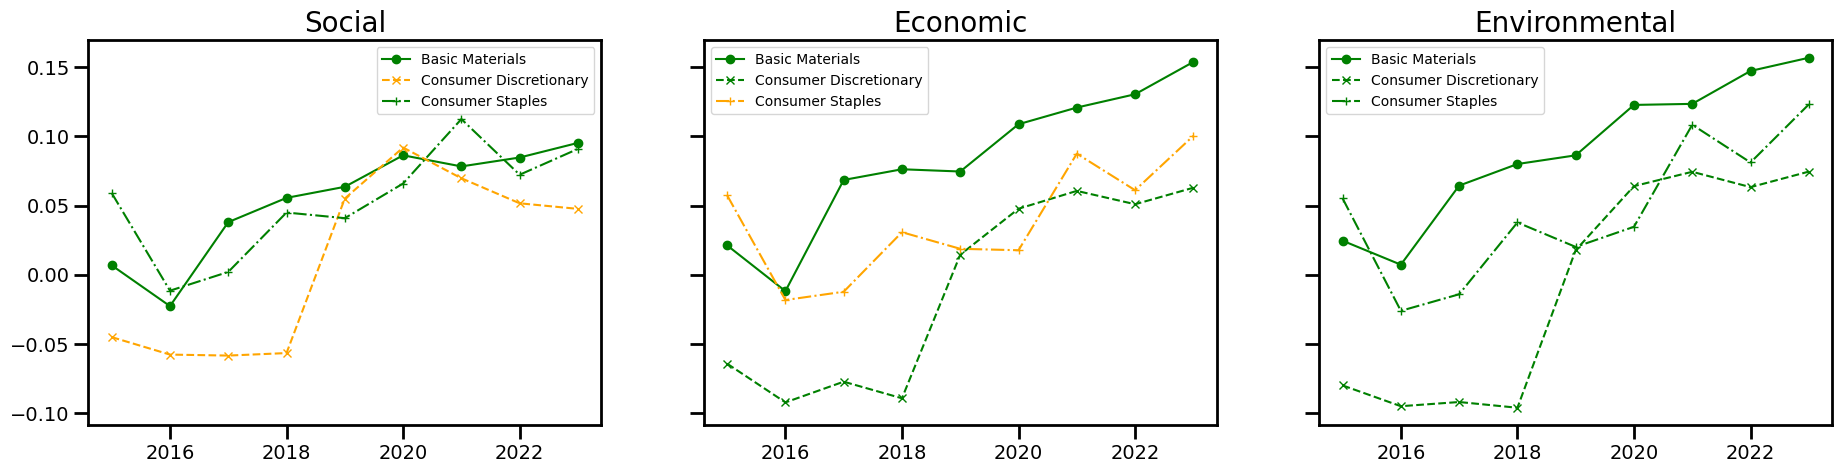

In [508]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 5), sharey=True)
for i_c, cluster in enumerate(sdg_sectors):
    for i_s, sec in enumerate(reliable_secs):
        _mean=cos_sims_sec_cluster[i_c*len(reliable_secs)+i_s]['mean']
        _aux=mk.original_test(_mean)
        axs[i_c].plot(np.arange(2015, 2024), _mean, marker=markers[i_s], c=trend_color[_aux.trend], label=sec_helper[sec], ls=ls[i_s])
        
    axs[i_c].set_title(sdg_sectors[i_c], fontsize=20)
    axs[i_c].legend()
plt.show()